## Forecasting Household Power Consumption: Insights from Time Series Analysis

#### Memebers of the Group: 

##### Aarti Aarti (Student ID:0833015 )
##### Neha Kumari (Student ID:0824764)
##### Sai Sri Kalyani Narapareddy (Student ID: 0827890)
##### Unnati Gawde (Student ID:0825955 )
##### Vikrant Siwach (Student ID:0824836 )

## Objective: 

### To apply all the models studied throughout the semester and find which one is a better fir for the data provided.

### Data Dictionary

#### Source: UCI 

#### Link: https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

#### The dataset contains 2075259 records gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months)

**Date**: The date is in the format dd/mm/yyyy.

**Time**: The time is in the format hh:mm:ss.

**Global Active Power**: This represents the total active power consumed by a household or an entire electrical grid, measured in kilowatts (kW). It indicates the real power used by electrical devices.

**Global Reactive Power**: This refers to the total reactive power consumption of a building or an electrical grid, measured in kilowatts (kW). Reactive power does not perform useful work but is essential for maintaining voltage levels in the system. It is expressed in volt-amperes reactive (VAR).

**Voltage**: Voltage, measured in volts (V), represents the average electrical potential energy per unit charge in a circuit. It drives the flow of electric charge in a circuit.

**Global Intensity**: This measures the overall or average current flow in an electrical system or network, such as a building or grid. It is measured in amperes (A) and represents the amount of electric charge moving through a conductor per unit of time.

**Sub-metering 1**: This records the energy consumption of devices in the kitchen, such as dishwashers, ovens, and microwaves, in watt-hours of active energy.

**Sub-metering 2**: This measures the energy consumption of devices in the laundry room, including washing machines, tumble dryers, refrigerators, and lights, in watt-hours of active energy.

**Sub-metering 3**: This tracks the energy consumption of an electric water heater and an air conditioner in watt-hours of active energy.

## Data Preprocessing

#### Combine the Seperate Date and Time Columns available to DateTime format to facilitate Forecast modeling.
#### The new column created (DateTime) has been set as Index as it is crucial for the Timeseries data to be used for Forecasting.
#### Changed DataType of all columns except Sub_metering 3 from Object to Float(Numeric Value).
#### Dropped the Null values - 25979 rows which isn't a high percentage and all the nulls were in Sub_metering 3 column.
#### Renamed the colums for visualization and clarity :
- 'Global_active_power'to 'Active Power (kW)'
- 'Global_reactive_power'to 'Reactive Power (kW)'
- 'Voltage'to 'Voltage (V)'
- 'Global_intensity'to 'Current Intensity (A)'
- 'Sub_metering_1'to 'Kitchen Energy (Wh)'
- 'Sub_metering_2'to 'Laundry Energy (Wh)'
- 'Sub_metering_3'to 'Water Heater & AC Energy (Wh)'

## Importing the necessary libraries and packages:

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings # ignore warnings 
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';')
df.head(5)

Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0

In [3]:
# created copy of dataframe for data manipulation
data = df 

In [4]:
data.shape

(2075259, 9)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


The data type of columns are not suitable for modeling so altering them.

#### Dropping the nulls

In [6]:
data.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [7]:
# Converting 'Date' and 'Time' columns to DateTime

data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Converting other columns to appropriate data types
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data['Global_reactive_power'] = pd.to_numeric(data['Global_reactive_power'], errors='coerce')
data['Voltage'] = pd.to_numeric(data['Voltage'], errors='coerce')
data['Global_intensity'] = pd.to_numeric(data['Global_intensity'], errors='coerce')
data['Sub_metering_1'] = pd.to_numeric(data['Sub_metering_1'], errors='coerce')
data['Sub_metering_2'] = pd.to_numeric(data['Sub_metering_2'], errors='coerce')

In [8]:
data = data.drop(['Date', 'Time'], axis=1)

In [9]:
print(data.dtypes)

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
DateTime                 datetime64[ns]
dtype: object


In [10]:
data.head()

Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3            DateTime  
0             0.0             1.0            17.0 2006-12-16 17:24:00  
1             0.0             1.0            16.0 2006-12-16 17:25:00  
2             0.0             2.0            17.0 2006-12-16 17:26:00  
3             0.0             1.0            17.0 2006-12-16 17:27:00  
4             0.0             1.0            17.0 2006-12-16 17:28:00

###  Setting DateTime column as  index

In [11]:
data.set_index('DateTime', inplace=True)

In [12]:
data.head()

Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
DateTime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [13]:
data = data.dropna(subset=['Sub_metering_3'])

In [14]:
data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [15]:
# Renaming the columns
data = data.rename(columns={
    'Global_active_power': 'Active Power (kW)',
    'Global_reactive_power': 'Reactive Power (kW)',
    'Voltage': 'Voltage (V)',
    'Global_intensity': 'Current Intensity (A)',
    'Sub_metering_1': 'Kitchen Energy (Wh)',
    'Sub_metering_2': 'Laundry Energy (Wh)',
    'Sub_metering_3': 'Water Heater & AC Energy (Wh)'
})

## Explorartory Data Analysis (EDA)

### Correlation Matrix

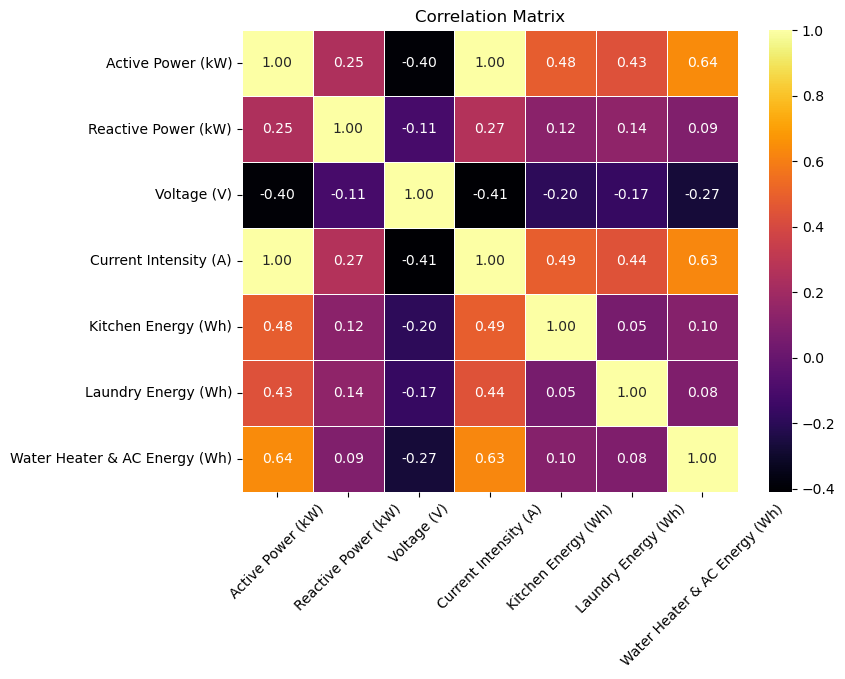

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop the "Month" column from the DataFrame
# data_without_month = data.drop(columns=['Month'])

# Compute the correlation matrix
correlation_matrix = data.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='inferno', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')

# Rotate the x-axis tick labels
plt.xticks(rotation=45)

plt.show()

Active Power (kW) has a weak positive correlation with Kitchen Energy (Wh) (0.48) and Laundry Energy (Wh) (0.43). This means that as active power increases, kitchen and laundry energy tend to increase as well, but the strength of the relationship is weak.
Active Power (kW) has a moderate negative correlation with Voltage (V) (-0.40) . This means that as active power increases, voltage tends to decrease, and vice versa.

Insights from the correlation matrix:

1. **Active Power and Current Intensity:** There's a perfect positive correlation of 1.00 between Active Power (kW) and Current Intensity (A), indicating that as the active power consumption increases, the current intensity also increases in a linear fashion.

2. **Active Power and Voltage:** There's a moderate negative correlation of -0.40 between Active Power (kW) and Voltage (V), suggesting that higher active power consumption is associated with a lower voltage, and vice versa.

3. **Energy Sub-metering:** Active Power has a strong positive correlation with all three sub-metering variables:
   - Kitchen Energy (Wh): 0.49
   - Laundry Energy (Wh): 0.44
   - Water Heater & AC Energy (Wh): 0.64

   This indicates that higher energy usage in these areas (kitchen, laundry, water heater, and AC) is associated with higher overall active power consumption.

4. **Reactive Power:** There's a very weak correlation between Reactive Power (kW) and the other variables, which indicates that reactive power doesn't vary in tandem with the active power or the sub-metering values in any substantial way.

5. **Sub-metering Relationships:** The sub-metering for kitchen and laundry shows very little correlation with each other (0.05), indicating that the energy usage in these two areas does not move together in any significant way. However, both have a low positive correlation with the Water Heater & AC Energy, with the latter having a stronger relationship (0.63 with Kitchen and 0.08 with Laundry), suggesting that when there is increased energy consumption for water heating and air conditioning, there tends to be a mild increase in kitchen and laundry energy usage as well.

6. **Voltage and Current Intensity:** A moderate negative correlation of -0.41 between Voltage (V) and Current Intensity (A) suggests that when more current flows through the system, the voltage tends to be lower, which could be due to increased load or resistance in the electrical system.

Overall, the matrix suggests that Active Power, which represents the main energy consumption, is closely related to the current flowing in the household and significantly influenced by the energy consumed by major appliances and systems (especially water heaters and ACs). The lack of correlation with 'Month' indicates that seasonality is not captured linearly in this data or the month variable was not encoded in a way to capture seasonal patterns.

### Writing functions to plot yearly, monthly, and weekly trends for code flexibility and resuability

- Note: Excluding 2006 data points as the volume is minimal( only december month records available)

In [17]:
def plot_yearly_pattern(data, column):
    data = data[data.index.year != 2006]  
    data['Year'] = data.index.year
    yearly_data = data.groupby('Year')[column].mean()
    plt.figure(figsize=(8, 6))
    yearly_data.plot(marker='o', linestyle='-')
    plt.title(f'Yearly Pattern of {column}')
    plt.xlabel('Year')
    plt.ylabel(column)
    plt.xticks(yearly_data.index)  
    plt.grid(True)
    plt.show()
    
def plot_weekly_pattern(data, column, year=None):
    if year:
        data = data[data.index.year == year]
    else:
        data = data[data.index.year != 2006]  
    
    weekly_data = data[column].resample('W').mean()
    
    # Get the start and end dates of each week
    week_starts = weekly_data.index.strftime('%Y-%m-%d')
    week_ends = (weekly_data.index + pd.DateOffset(days=6)).strftime('%Y-%m-%d')
    
    plt.figure(figsize=(18, 6)) 
    plt.plot(weekly_data.index, weekly_data, marker='o', linestyle='-')
    plt.title(f'Weekly Pattern of {column} ({year if year else "All Years"})')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.grid(True)
    
    # Set x-axis labels as week start and week end dates for alternate weeks
    alternate_dates = [f'{start}\n{end}' for i, (start, end) in enumerate(zip(week_starts, week_ends)) if i % 2 == 0]
    alternate_indices = [i for i in range(len(week_starts)) if i % 2 == 0]  
    plt.xticks(weekly_data.index[alternate_indices], alternate_dates, rotation=45)
    
    plt.show()


def plot_seasonal_pattern(data, column, year=None):
    if year:
        data = data[data.index.year == year]
    else:
        data = data[data.index.year != 2006] 
    
    data['Year_Month'] = data.index.to_period('M')  
    seasonal_data = data.groupby('Year_Month')[column].mean()
    
    plt.figure(figsize=(12, 6))
    seasonal_data.plot(marker='o', linestyle='-')
    plt.title(f'Seasonal Pattern of {column} ({year if year else "All Years"})')
    plt.xlabel('Year_Month')
    plt.ylabel(column)
    plt.grid(True)
    plt.xticks(rotation=45)  
    plt.show()

#### Yearly trends

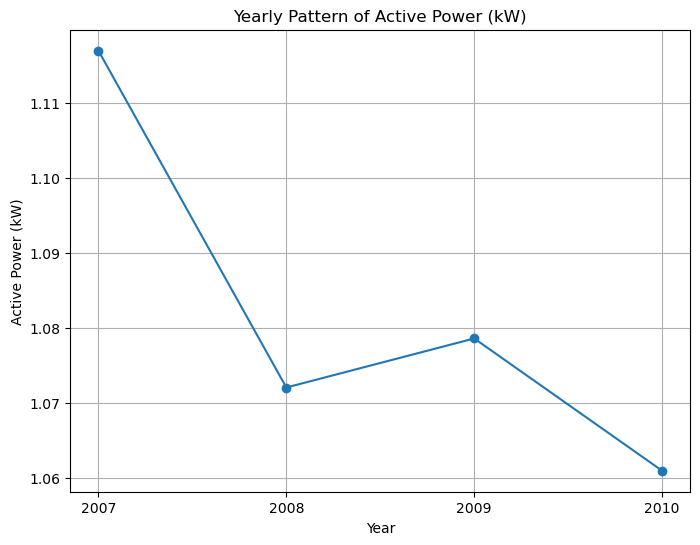

In [18]:
plot_yearly_pattern(data, 'Active Power (kW)')

- 2007 has a higher overall level of active power compared to the other years.

The line graph above shows the yearly pattern of active power consumption (in kW) from 2007 to 2010. 

### Inferences/Observations:

1. **Decline from 2007 to 2008:** There was a significant drop in active power usage from 2007 to 2008, indicating a possible reduction in energy consumption or improved energy efficiency.

2. **Stabilization from 2008 to 2009:** The active power consumption appears to stabilize from 2008 to 2009, with only a slight increase, suggesting that consumption patterns remained relatively constant during this period.

3. **Decrease in 2010:** There's another noticeable decrease in active power consumption in 2010 compared to 2009, which could be attributed to various factors such as changes in household behavior, energy conservation measures, or external factors not depicted in the graph.

4. **Overall Trend:** Over the four years, there is a general downward trend in active power consumption, which might reflect an overarching trend towards more energy-efficient practices or appliances in households.

This graph could be useful for energy suppliers in understanding changes in demand over time and for households aiming to track and manage their energy usage.

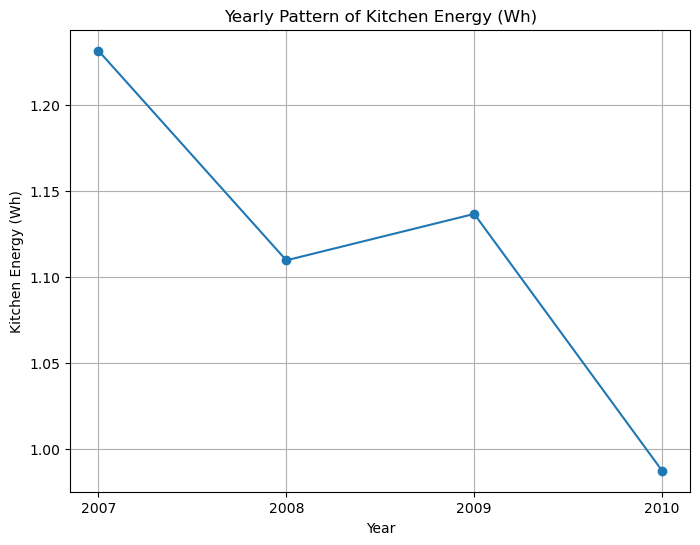

In [19]:
plot_yearly_pattern(data, 'Kitchen Energy (Wh)')

The line graph illustrates the yearly pattern of kitchen energy usage in watt-hours (Wh) from 2007 to 2010. 

### Inferences/Observations:

1. **Sharp Decrease from 2007 to 2008:** There's a notable drop in kitchen energy consumption from 2007 to 2008. This could indicate a change in kitchen appliance usage or improvements in energy efficiency.

2. **Increase from 2008 to 2009:** The consumption goes up slightly in 2009, which may suggest changes in household habits or the introduction of new kitchen appliances that consume more energy.

3. **Significant Decrease in 2010:** A substantial decline in energy usage is observed in 2010. This could be due to further energy-saving measures, less usage of kitchen appliances, or other factors not evident from the graph alone.

4. **Overall Trend:** The overall trend from 2007 to 2010 shows a decrease in energy consumption in the kitchen, which could be reflective of a longer-term trend toward more efficient kitchen habits or appliances.

5. **Implications:** This downward trend could be of interest to utility companies for demand-side management and to households for tracking energy efficiency improvements in the kitchen area.

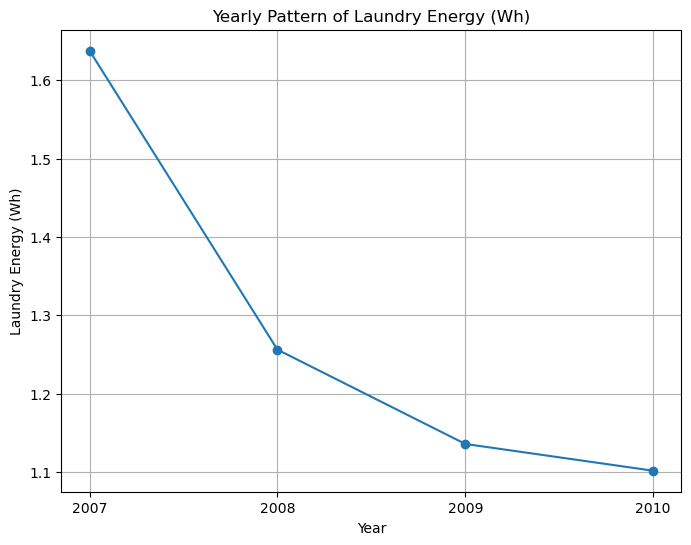

In [20]:
plot_yearly_pattern(data, 'Laundry Energy (Wh)')

The line graph above depicts the yearly pattern of laundry energy consumption in watt-hours (Wh) from 2007 to 2010.

### Inferences/Observations:

1. **Significant Decrease from 2007 to 2008:** There's a pronounced decline in laundry energy usage, possibly due to changes in laundry habits, more efficient usage of machines, or upgrading to more energy-efficient appliances.

2. **Gradual Decline from 2008 to 2010:** Following 2008, the graph shows a continued but more gradual decrease in energy consumption over the next two years, suggesting a sustained trend of energy-saving in laundry activities.

3. **Overall Trend:** The overall trend across the four years is a steady decrease in the energy used for laundry, indicating consistent improvements in energy efficiency or reductions in usage frequency/intensity.

4. **Implications:** This information could be vital for energy conservation efforts, as it suggests a potential reduction in one of the household's significant energy-consuming activities. It could influence utility planning for energy demand and supply, and also guide consumers seeking to reduce their energy footprint.

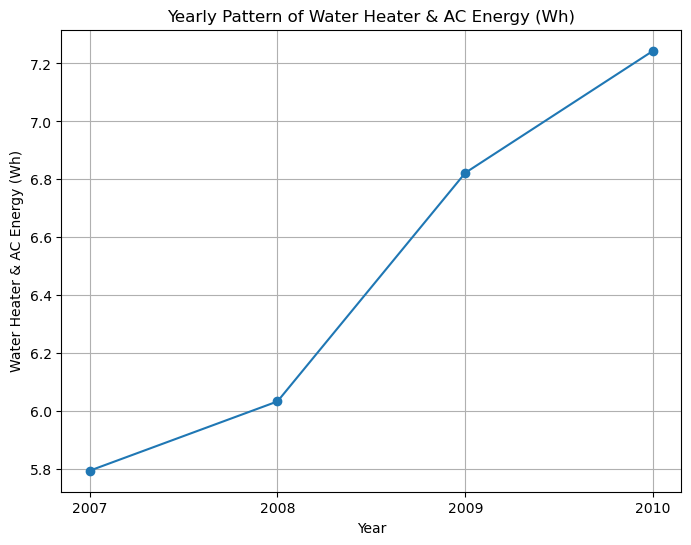

In [21]:
plot_yearly_pattern(data, 'Water Heater & AC Energy (Wh)')

The line graph above shows the yearly pattern of energy consumption in watt-hours (Wh) attributed to water heaters and air conditioning (AC) from 2007 to 2010. 

### Inferences/Observations:

1. **Upward Trend:** Unlike the trends observed for kitchen and laundry energy consumption, water heater and AC usage shows a consistent upward trend over the four years.

2. **Yearly Increase:** Each year, there is an increase in consumption, with the steepest rise occurring between 2009 and 2010.

3. **Higher Energy Demand for Heating and Cooling:** The increasing trend suggests growing energy demand for water heating and air conditioning, which could be due to various factors, such as more extreme weather conditions, increased comfort standards, or additional installations of such appliances in households.

4. **Implications:** The trend indicates that energy usage for heating and cooling is a growing part of the household energy profile, which could have implications for energy planning, especially for peak demand times, and points towards the need for more energy-efficient heating and cooling solutions.

### Monthly(Seasonal) Trends

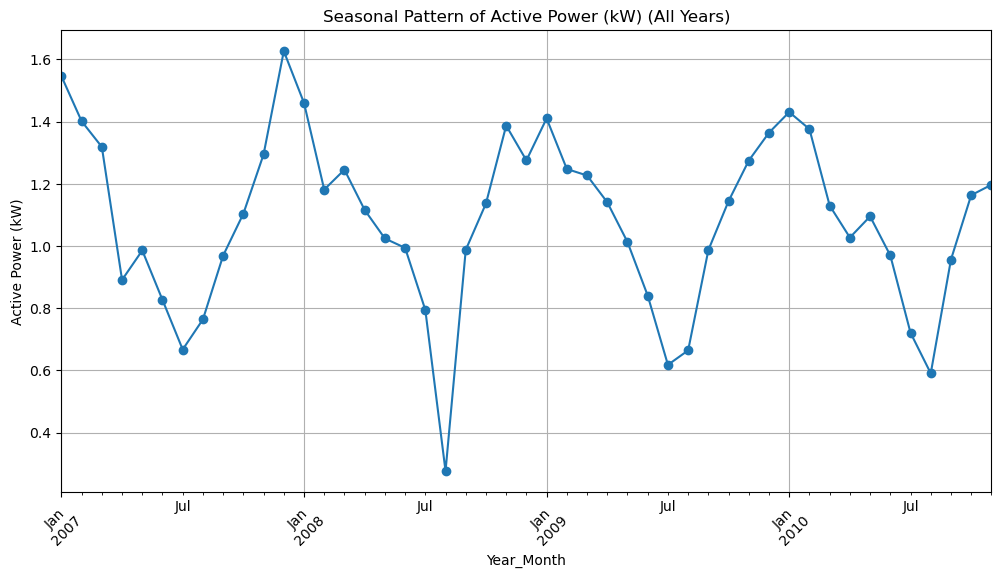

In [22]:
plot_seasonal_pattern(data, 'Active Power (kW)')

The line graph above illustrates the seasonal pattern of active power consumption (in kW) over several years. 

### Inferences/Observations:

1. **Seasonal Variability:** There are clear seasonal fluctuations in power usage with peaks and troughs occurring around the same time each year.

2. **Peak Consumption:** The highest power usage typically occurs mid-year, likely corresponding with summer when air conditioning use is higher.

3. **Lowest Consumption:** The lowest points in power consumption generally occur at the beginning of the year, which may correspond with milder weather conditions requiring less heating or cooling.

4. **Year-to-Year Trends:** While seasonal patterns are consistent, there’s a year-to-year variability indicating that other factors may also influence consumption.

This data can help utilities in planning for seasonal demand and encourage consumers to adopt energy-saving measures during peak periods.

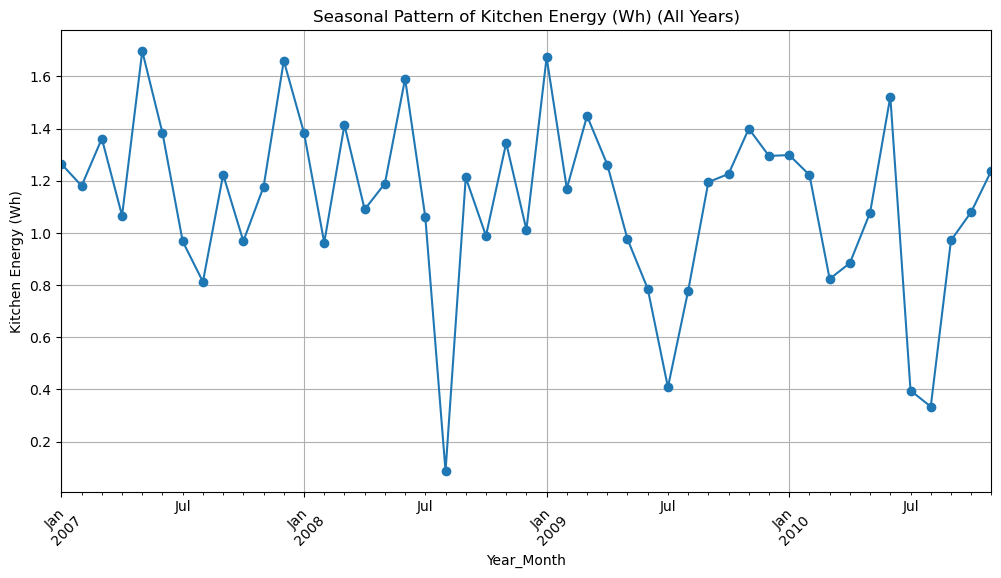

In [23]:
plot_seasonal_pattern(data, 'Kitchen Energy (Wh)')

The line graph displays the seasonal pattern of kitchen energy consumption (in Wh) across several years. 

### Inferences/Observations:

1. **Seasonal Fluctuations:** There is a consistent pattern of peaks and troughs that repeat annually, indicating a strong seasonal influence on kitchen energy usage.

2. **Peaks:** The highest points of energy usage typically occur in the mid and end of each year. This could be related to specific seasonal activities or holidays that involve more cooking and kitchen appliance usage.

3. **Troughs:** The lowest points occur early in the year and around mid-year, suggesting periods of reduced kitchen activity or lower appliance use.

4. **Overall Pattern:** The pattern is cyclical with regular variations, hinting at the influence of external factors such as climate, holidays, or household routines that affect kitchen energy use.

This data can inform energy-saving strategies and utility load forecasting by highlighting periods of high and low kitchen energy demand.

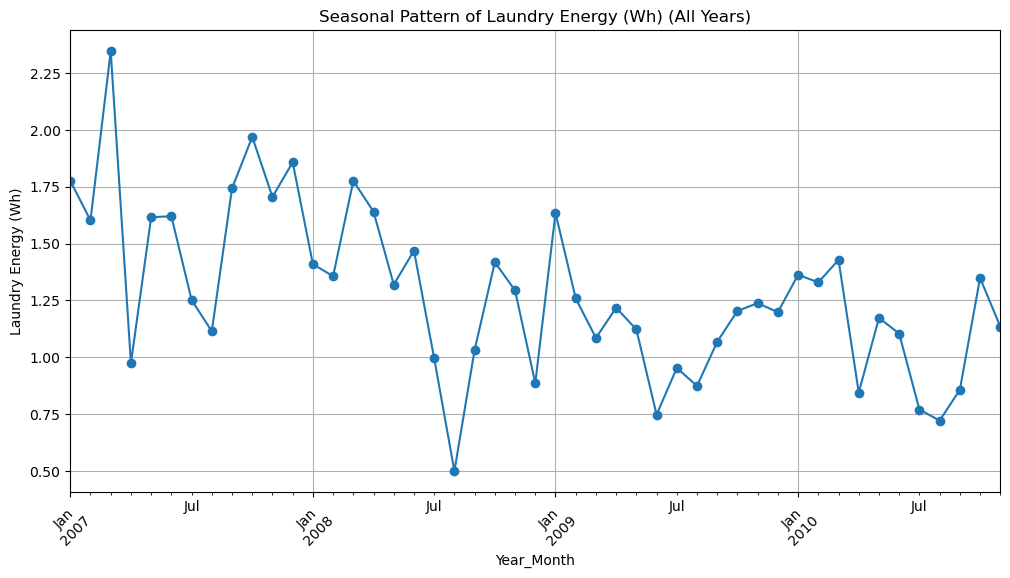

In [24]:
plot_seasonal_pattern(data, 'Laundry Energy (Wh)')

The line graph illustrates the seasonal pattern of laundry energy consumption (in Wh) over several years. 

### Inferences/Observations:

1. **Seasonal Variation:** There are noticeable fluctuations in laundry energy usage throughout the year, which suggest a seasonal impact on laundry habits.

2. **Peaks and Troughs:** Peaks in energy consumption can be observed during certain months, with notable troughs or dips at other times. This could correspond to seasonal changes, such as more frequent washing in warmer months or during specific holiday periods when laundry loads may increase.

3. **Increasing Trend Over Time:** In the latter years, particularly from mid-2009 to mid-2010, there is a trend of rising peaks, indicating an increase in laundry energy consumption during those periods compared to previous years.

4. **Irregularities:** Some irregularities, like the sharp drop at the beginning of 2008 and the significant peak in early 2010, could be due to external factors or data anomalies.

This pattern may reflect changes in consumer behavior or external factors such as weather variations influencing laundry routines. Understanding these patterns can assist in energy management and optimizing the operation of utilities.

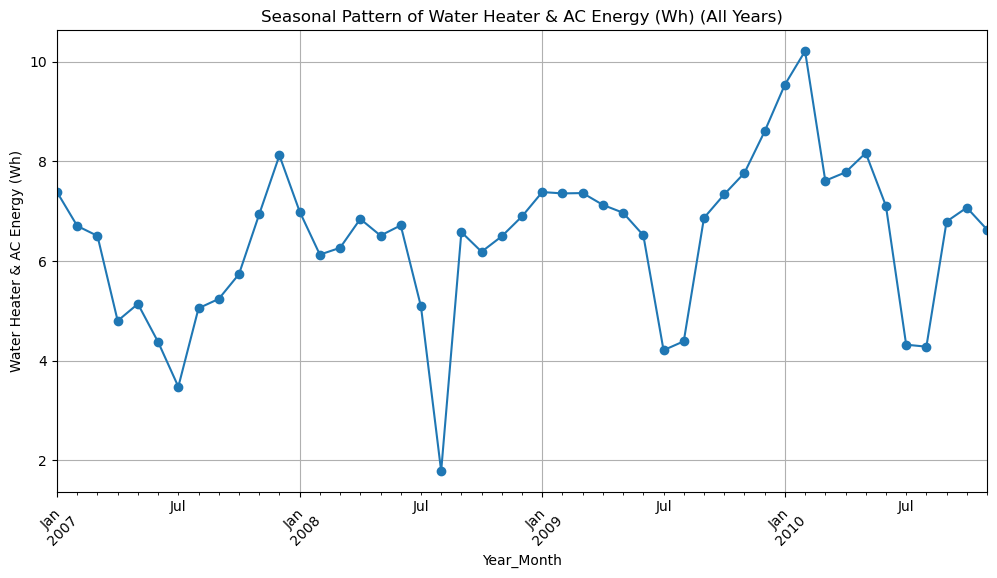

In [25]:
plot_seasonal_pattern(data, 'Water Heater & AC Energy (Wh)')

The line graph depicts the seasonal pattern of energy consumption for water heaters and air conditioning (AC) over several years. 

### Inferences/Observations:

1. **Seasonal Peaks:** The energy consumption peaks predominantly during certain months, which could correspond with the winter and summer seasons when heating and cooling needs are higher.

2. **Valleys in Usage:** There are noticeable valleys in the graph where energy usage dips, possibly indicating milder weather periods where less heating or cooling is required.

3. **Yearly Variation:** The magnitude of the peaks and valleys varies from year to year, suggesting that yearly differences in weather, household behavior, or other factors are affecting energy usage.

4. **High Consumption in 2010:** In the year 2010, there's a significant peak in energy consumption, indicating a particularly high demand for heating or cooling.

This graph is indicative of the significant impact of seasonality on the usage of water heating and air conditioning systems, which can be critical for energy management and load forecasting by utilities.

### Weekly Trends (2009)

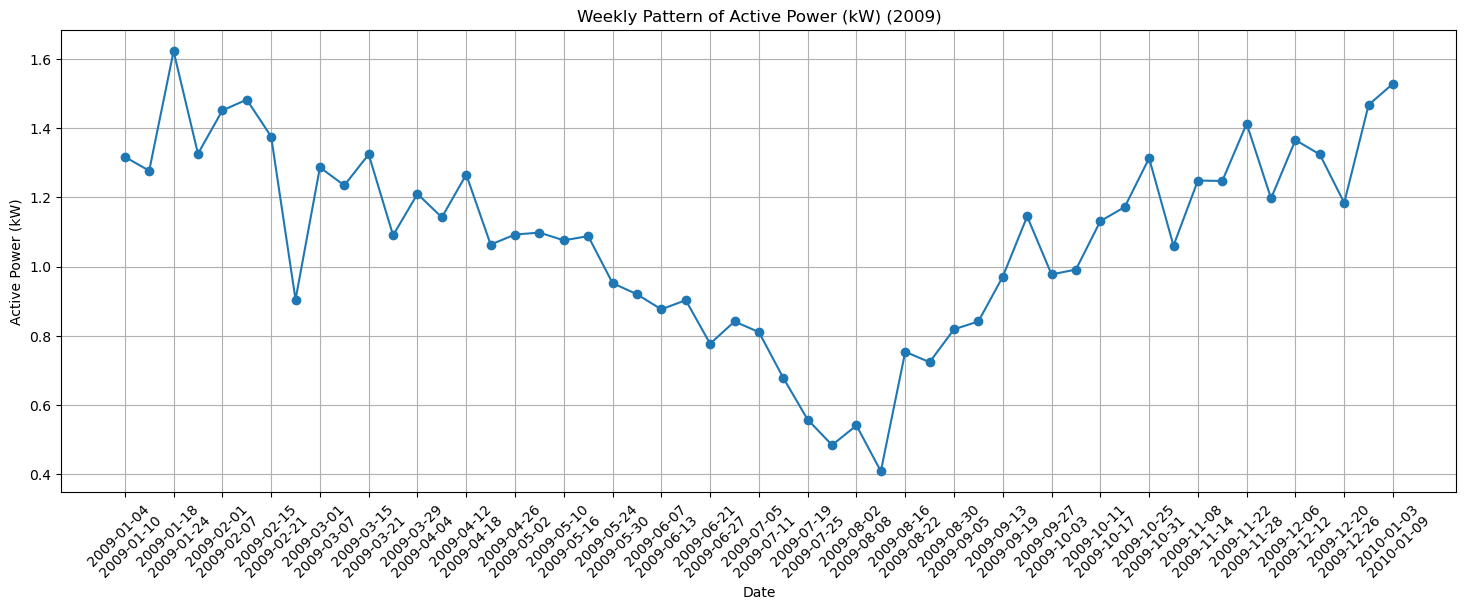

In [26]:
plot_weekly_pattern(data, 'Active Power (kW)', year=2009)

The line graph displays the weekly pattern of active power consumption (in kW) for the year 2009. 

### Observations/Inferences:

1. **Variability:** There is significant week-to-week variability in power usage, with no smooth or predictable pattern, which could indicate fluctuating activity or varying external factors influencing weekly power consumption.

2. **Mid-Year Trough:** There's a notable trough in consumption around mid-year, possibly suggesting reduced usage or higher efficiency during this period, which may coincide with milder weather reducing the need for heating or cooling.

3. **End-of-Year Increase:** Starting from the latter half of the year, there is a general uptrend in consumption, peaking towards the end of the year, which might reflect increased heating requirements due to colder weather.

4. **Short-Term Fluctuations:** Short-term fluctuations may indicate events or behavior changes on a weekly basis, such as varying occupancy, holidays, or other temporary factors that impact power use.

This information is useful for detailed load forecasting on a short-term basis and can help in understanding weekly consumption patterns to better manage energy distribution.

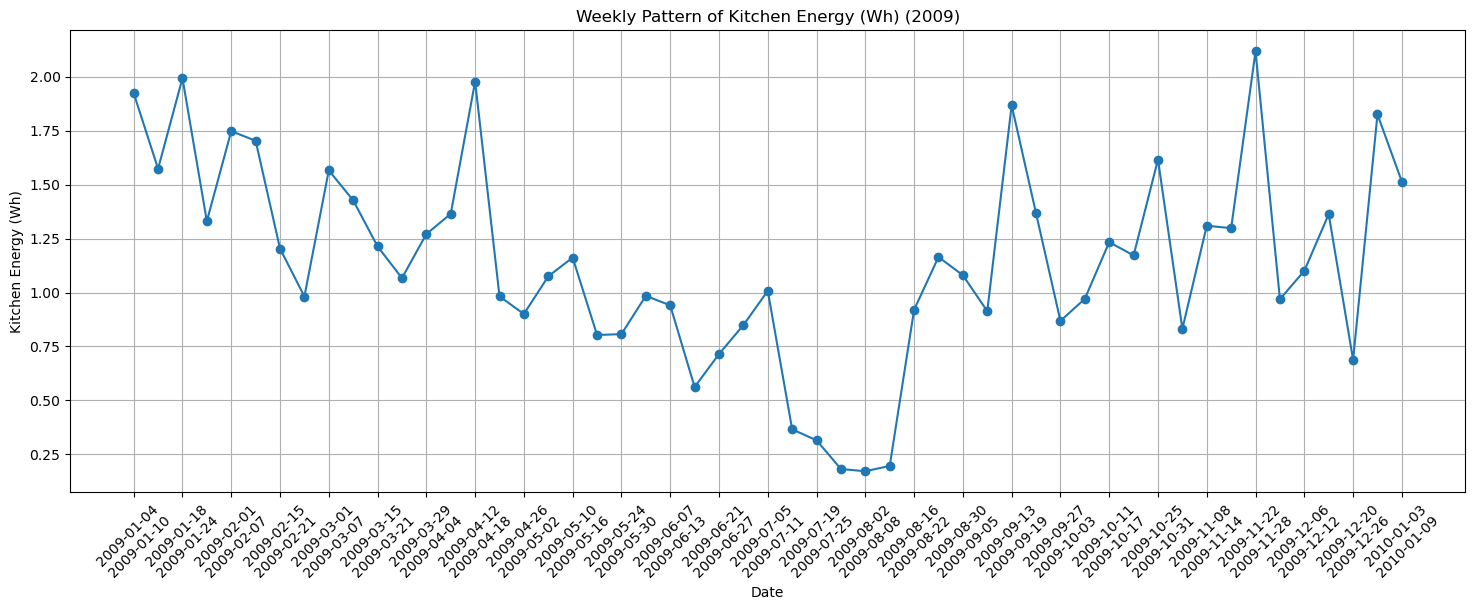

In [27]:
plot_weekly_pattern(data, 'Kitchen Energy (Wh)', year=2009)

The line graph shows the weekly pattern of kitchen energy usage (in Wh) for the year 2009. 

### Observations/Inferences:

1. **Fluctuations:** There is significant week-to-week variation in kitchen energy consumption, indicative of fluctuating use patterns, possibly due to changing household routines or special occasions that influence kitchen activity.

2. **Mid-Year Dip:** A pronounced dip in energy usage around mid-year suggests a period where the kitchen was used less frequently or more efficiently. This could correspond with a time when inhabitants are away (e.g., summer vacations) or other behavioral factors.

3. **End-of-Year Increase:** There's a noticeable increase toward the end of the year, likely related to the holiday season when kitchen activity typically increases due to festive cooking and gatherings.

4. **General Volatility:** The graph displays high volatility in kitchen energy usage, which could be due to inconsistent use of kitchen appliances from week to week.

Understanding such patterns can help in planning for more efficient energy use and could be crucial for developing strategies to reduce overall household energy consumption.

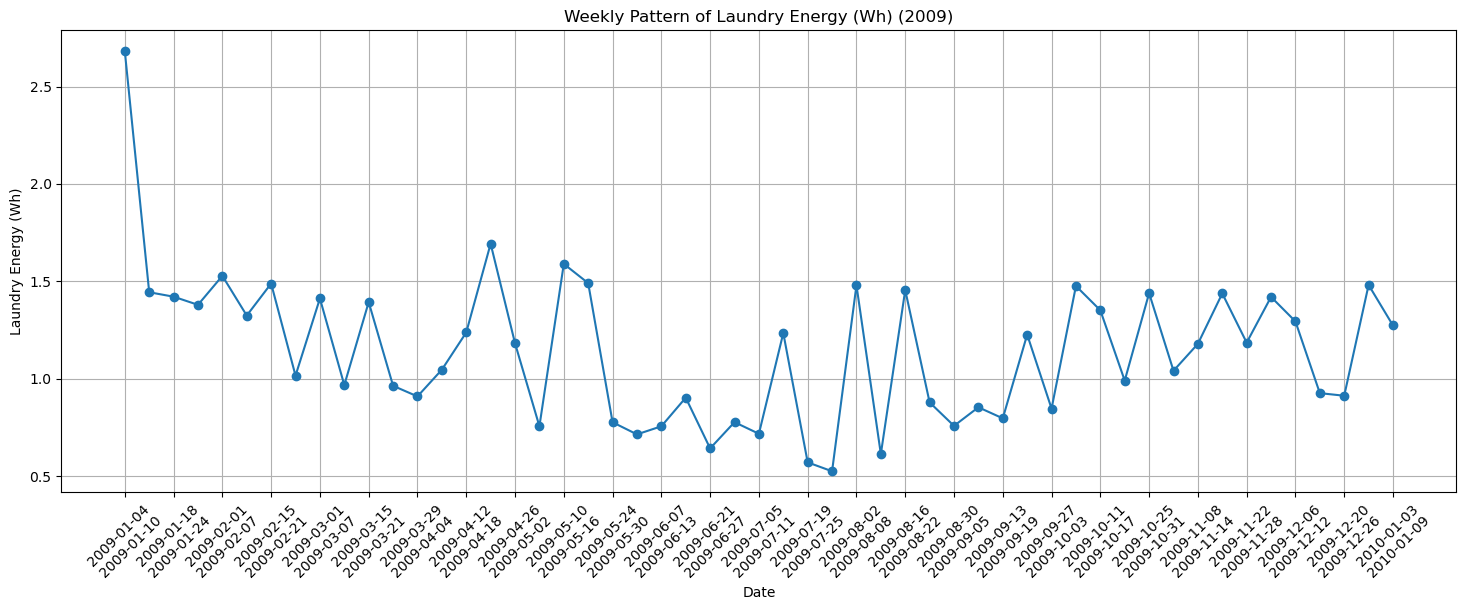

In [28]:
plot_weekly_pattern(data, 'Laundry Energy (Wh)', year=2009)

The line graph shows the weekly pattern of laundry energy consumption (in Wh) for the year 2009. 

### Inferences/Observations:

1. **Sharp Initial Drop:** The year starts with a significant drop in laundry energy usage, which quickly stabilizes.

2. **Consistent Fluctuations:** Throughout the year, there is noticeable variability, with several peaks indicating weeks of higher laundry activity.

3. **Mid-Year Low Point:** There is a pronounced dip in usage around the middle of the year, potentially due to warmer weather when less laundry is done or clothing is air-dried.

4. **End-of-Year Activity Increase:** Toward the year's end, there's an uptick in energy usage, possibly due to colder weather necessitating more frequent laundering of clothing and use of dryers.

The pattern reflects a combination of habitual laundry routines and possible seasonal impacts, which could inform energy usage strategies and efficiency improvements.

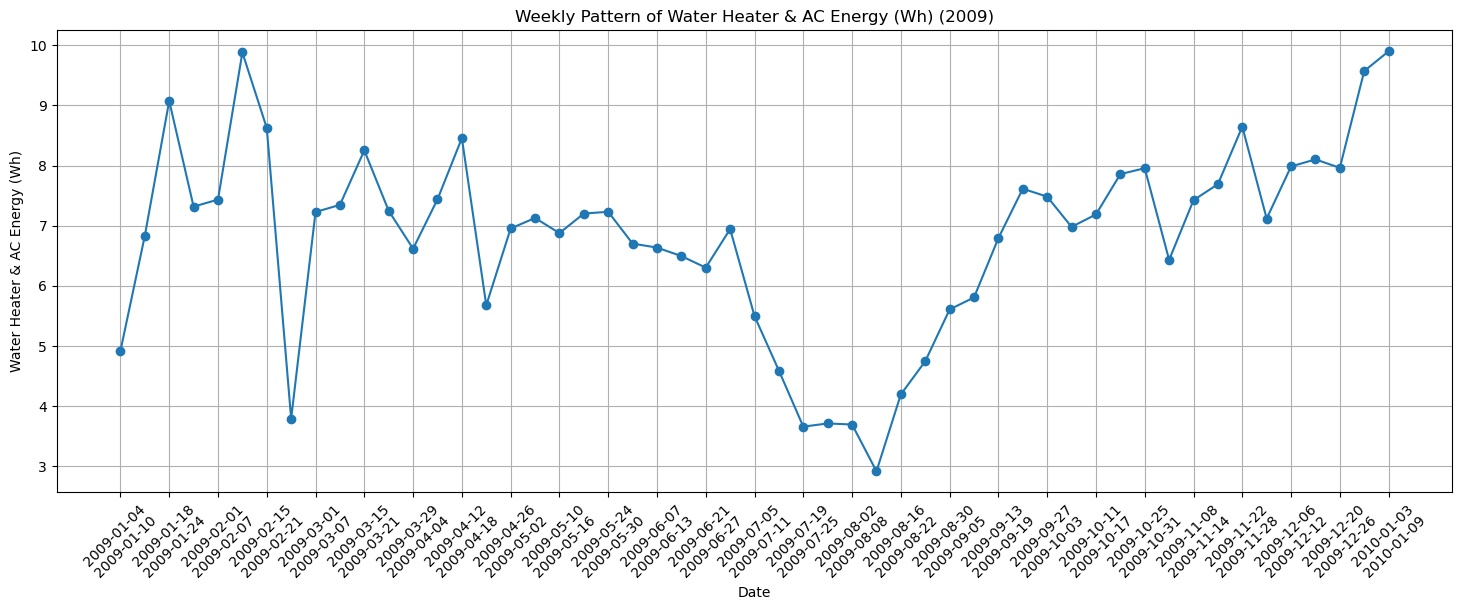

In [29]:
plot_weekly_pattern(data, 'Water Heater & AC Energy (Wh)', year=2009)

The line graph depicts the weekly pattern of combined energy consumption for water heaters and air conditioning (AC) in watt-hours (Wh) for the year 2009. 

### Inferences/Observations:

1. **Significant Weekly Variation:** The graph shows a high degree of variability from week to week, suggesting that energy usage for heating and cooling is influenced by short-term factors, possibly including fluctuations in weather or changes in household routines.

2. **Mid-Year Dip:** There is a notable decrease in energy usage around mid-year. This may indicate a period with less reliance on heating and cooling, potentially due to moderate weather.

3. **End-of-Year Increase:** A marked increase in energy usage towards the end of the year suggests a higher demand for heating with the onset of cooler temperatures.

4. **Usage Peaks:** Several peaks are seen throughout the year, which could be associated with extreme weather events necessitating more water heating or air conditioning.

The pattern suggests that energy usage for water heating and AC is highly responsive to immediate environmental conditions and household needs on a weekly basis. Understanding these patterns could help in the planning and management of energy demand and supply strategies.

## Moving Average

In [30]:
def plot_weekly_pattern(data, column, year=None, window_size=2):
    if year:
        data = data[data.index.year == year]
    else:
        data = data[data.index.year != 2006]  
    
    weekly_data = data[column].resample('W').mean()
    weekly_ma = weekly_data.rolling(window=window_size, min_periods=1).mean()  
    
    print("Weekly Data:")
    print(weekly_data.head())
    print("\nWeekly Moving Average:")
    print(weekly_ma.head())
    
    if weekly_data.empty or weekly_ma.empty:
        print("Error: Weekly data or moving average is empty.")
        return
    
    plt.figure(figsize=(18, 6))
    plt.plot(weekly_data.index, weekly_data, marker='o', linestyle='--', label='Actual Values')
    plt.plot(weekly_ma.index, weekly_ma,marker='X', linestyle='--', color='red', label=f'{window_size}-Week Moving Average')
    plt.title(f'Weekly Pattern of {column} ({year if year else "All Years"})')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_seasonal_pattern(data, column, year=None, window_size=4):
    if year:
        data = data[data.index.year == year]
    data['Month'] = data.index.month
    seasonal_data = data[column].resample('M').mean()
    seasonal_ma = seasonal_data.rolling(window=window_size, min_periods=1).mean()  
    
    print("Seasonal Data:")
    print(seasonal_data.head())
    print("\nSeasonal Moving Average:")
    print(seasonal_ma.head())
    
    if seasonal_data.empty or seasonal_ma.empty:
        print("Error: Seasonal data or moving average is empty.")
        return
    
    plt.figure(figsize=(18, 6))
    plt.plot(seasonal_data.index, seasonal_data, marker='o', linestyle='--', label='Actual Values')
    plt.plot(seasonal_ma.index, seasonal_ma,marker='x', linestyle='--', color='red', label=f'{window_size}-Month Moving Average')
    plt.title(f'Seasonal Pattern of {column} ({year if year else "All Years"})')
    plt.xlabel('Month')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()

### Active Power (kW)

Weekly Data:
DateTime
2007-01-07    1.484233
2007-01-14    1.604954
2007-01-21    1.639451
2007-01-28    1.517470
2007-02-04    1.703608
Freq: W-SUN, Name: Active Power (kW), dtype: float64

Weekly Moving Average:
DateTime
2007-01-07    1.484233
2007-01-14    1.544594
2007-01-21    1.576213
2007-01-28    1.561527
2007-02-04    1.616371
Freq: W-SUN, Name: Active Power (kW), dtype: float64


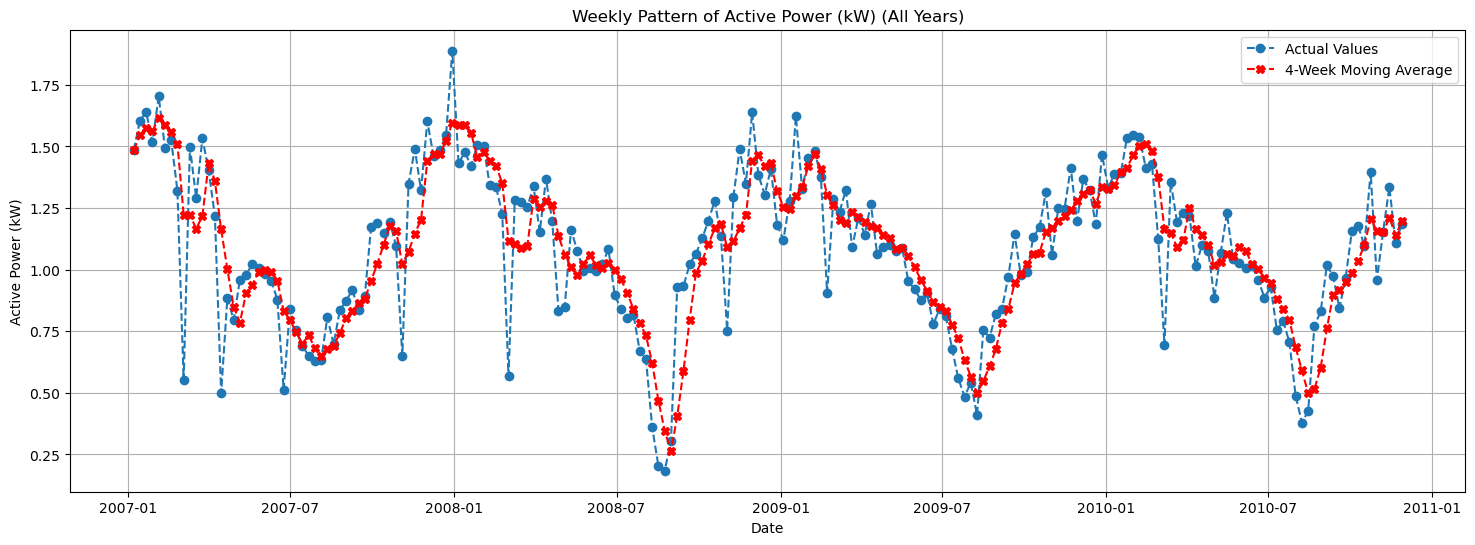

In [31]:
# Ploting weekly pattern with moving average
plot_weekly_pattern(data, 'Active Power (kW)', window_size=4)

The graph presents the weekly pattern of active power (kW) consumption over multiple years alongside a 4-week moving average. 

### Inferences/Observations:

1. **Actual vs. Moving Average:** The actual values show significant variability, while the 4-week moving average smooths out short-term fluctuations, providing a clearer view of the underlying trend.

2. **Seasonal Trends:** Both the actual values and the moving average indicate seasonal cycles, with peaks likely in the colder and warmer months due to heating and cooling needs and troughs during milder weather.

3. **Yearly Comparisons:** The moving average allows for easier comparison between years, showing how consumption trends might be changing over time.

4. **Anomalies:** The moving average helps to identify outliers or anomalies in the actual data, which might be due to special events or data recording issues.

5. **Overall Pattern:** There’s a clear pattern of power consumption that repeats annually, emphasizing the impact of seasonality on household energy use.

This graph can aid utility companies in planning for peak load periods and can also help consumers identify times when they might want to cut back on energy use to save on costs.

Seasonal Data:
DateTime
2006-12-31    1.901295
2007-01-31    1.546034
2007-02-28    1.401084
2007-03-31    1.318627
2007-04-30    0.891189
Freq: M, Name: Active Power (kW), dtype: float64

Seasonal Moving Average:
DateTime
2006-12-31    1.901295
2007-01-31    1.723665
2007-02-28    1.616138
2007-03-31    1.541760
2007-04-30    1.289233
Freq: M, Name: Active Power (kW), dtype: float64


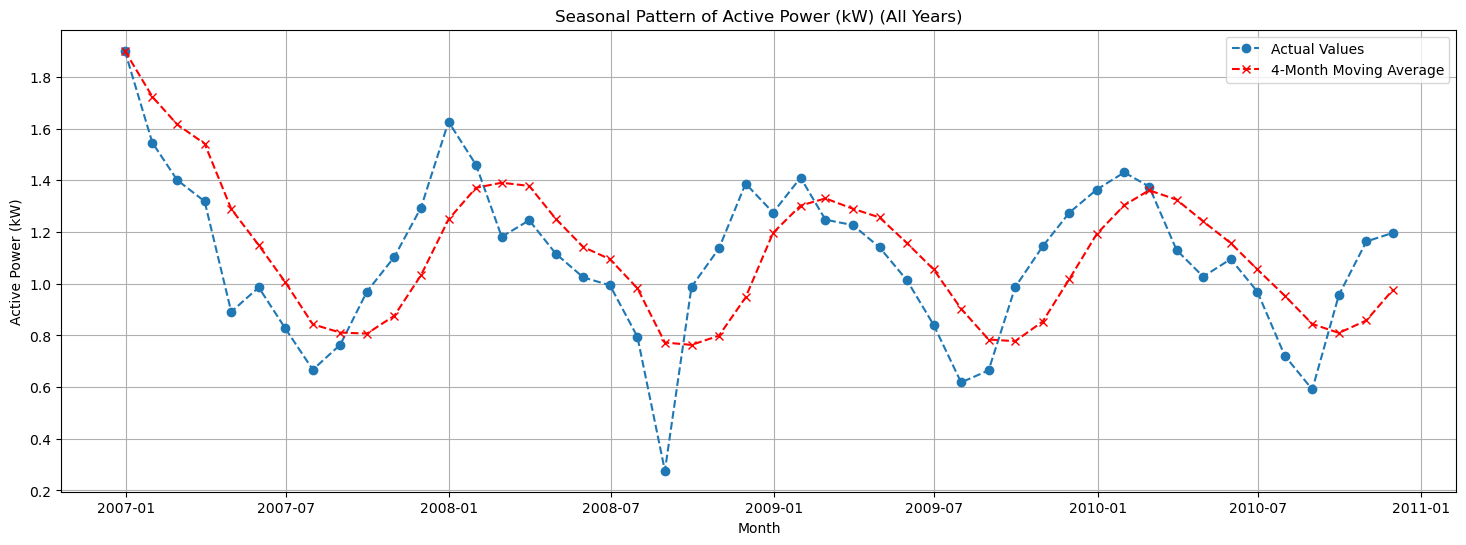

In [32]:
# Ploting seasonal pattern with moving average
plot_seasonal_pattern(data, 'Active Power (kW)', window_size=4)

The above plot shows the seasonal pattern of active power consumption (kW) along with a 4-month moving average. 

### Inferences/Observations:

1. **Seasonal Cycles:** Both the actual values and the moving average exhibit clear seasonal cycles, with peaks typically in summer and winter, likely due to cooling and heating needs.

2. **Smoothing Effect:** The 4-month moving average smooths out the short-term fluctuations and reveals the underlying seasonal trend, making the peaks and troughs more discernible.

3. **Year to Year Trend:** The moving average indicates a relatively consistent pattern from year to year, with minor variations in the amplitude of peaks and troughs.

4. **Valley Points:** The lowest points in the moving average usually occur in the transitional seasons, like spring and fall, when there is generally less need for heating or cooling.

5. **Peak Fluctuations:** The actual values show some erratic peaks which could be attributed to specific events or anomalous weeks, which are not reflected in the moving average due to its smoothing effect.

This pattern of active power usage is critical for understanding demand trends in energy planning and can be used to adjust supply strategies and grid management accordingly.

### Kitchen Energy (Wh)

Weekly Data:
DateTime
2007-01-07    0.581052
2007-01-14    1.331481
2007-01-21    2.324901
2007-01-28    1.138506
2007-02-04    1.146131
Freq: W-SUN, Name: Kitchen Energy (Wh), dtype: float64

Weekly Moving Average:
DateTime
2007-01-07    0.581052
2007-01-14    0.956266
2007-01-21    1.412478
2007-01-28    1.343985
2007-02-04    1.485255
Freq: W-SUN, Name: Kitchen Energy (Wh), dtype: float64


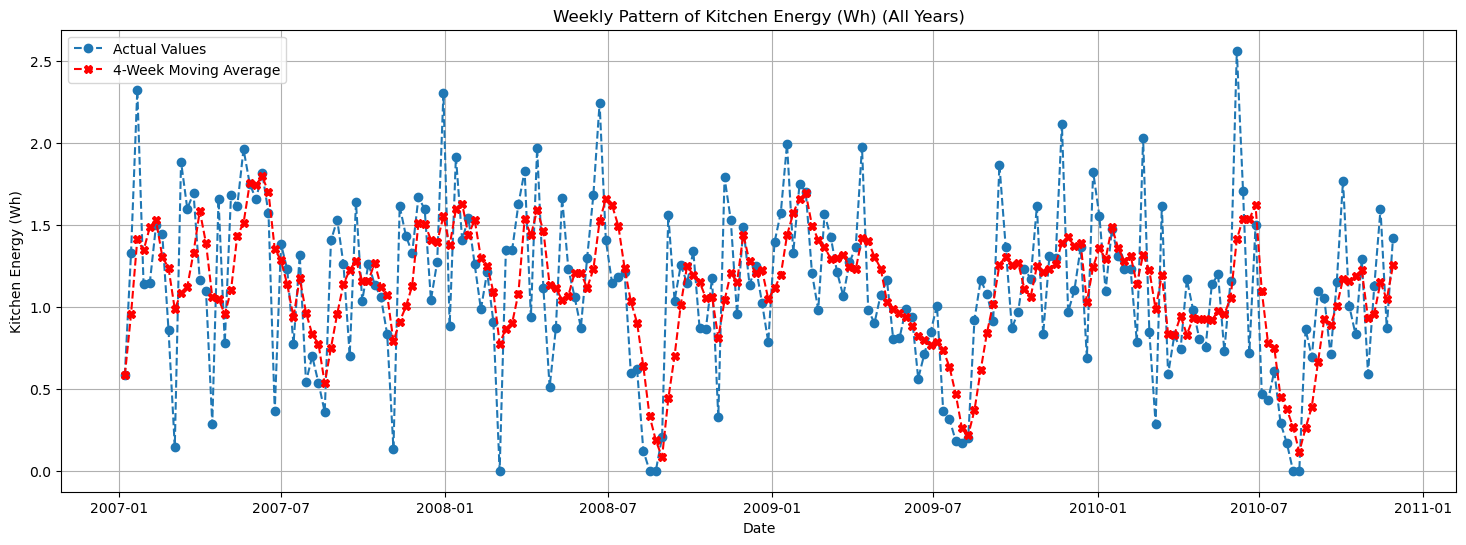

In [33]:
# Ploting weekly pattern with moving average
plot_weekly_pattern(data, 'Kitchen Energy (Wh)', window_size=4)

This graph illustrates the weekly kitchen energy consumption in watt-hours (Wh), comparing actual values to a 4-week moving average over multiple years:

1. **Weekly Variability:** There's substantial variability in the actual weekly data points, which is typical for household energy usage.

2. **4-Week Moving Average:** The moving average smooths out these fluctuations, showing a more stable trend line that gives a clearer picture of the overall usage pattern.

3. **Seasonal Patterns:** The moving average suggests there may be a seasonal pattern to kitchen energy usage, with peaks and valleys occurring at similar times each year.

4. **Trend Identification:** The moving average helps to identify broader trends that may not be immediately apparent from the actual data due to its volatility.

5. **Data Outliers:** The actual data show some extreme values (spikes) that could represent atypical usage or data anomalies.

Understanding the moving average trend is crucial for managing energy supply, planning for energy efficiency measures, and possibly informing household budgeting for energy costs.

Seasonal Data:
DateTime
2006-12-31    1.248636
2007-01-31    1.264237
2007-02-28    1.180217
2007-03-31    1.361343
2007-04-30    1.065886
Freq: M, Name: Kitchen Energy (Wh), dtype: float64

Seasonal Moving Average:
DateTime
2006-12-31    1.248636
2007-01-31    1.256436
2007-02-28    1.231030
2007-03-31    1.263608
2007-04-30    1.217921
Freq: M, Name: Kitchen Energy (Wh), dtype: float64


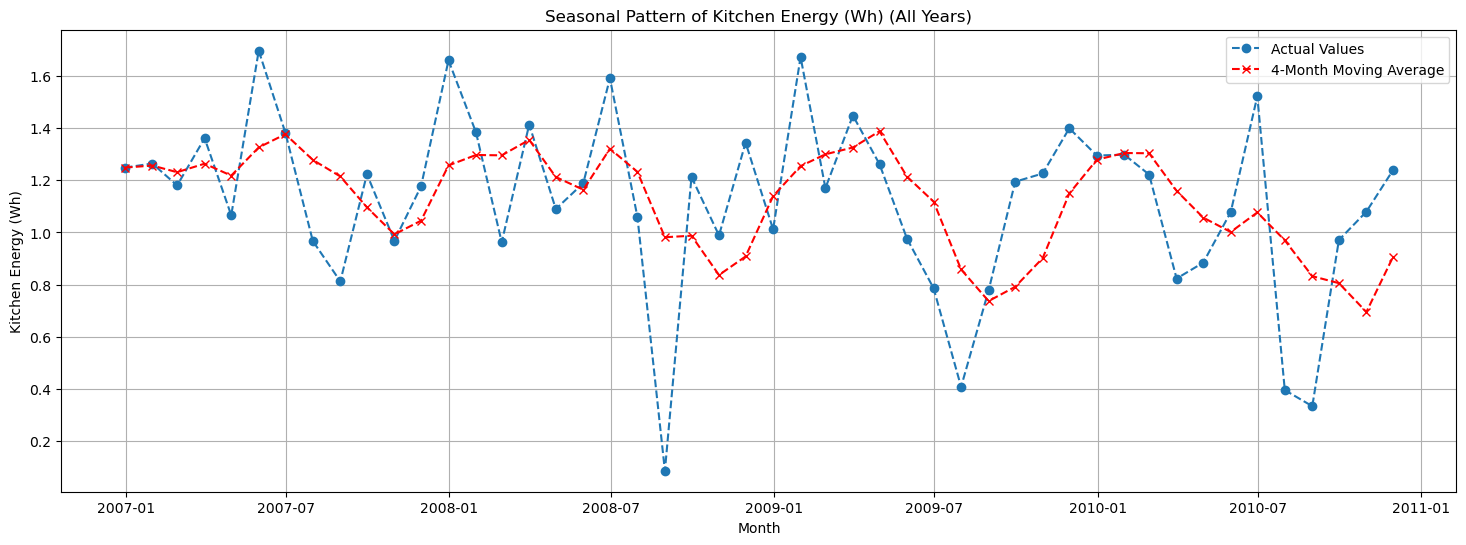

In [34]:
# Ploting seasonal pattern with moving average
plot_seasonal_pattern(data, 'Kitchen Energy (Wh)', window_size=4)

The graph presents the seasonal pattern of kitchen energy consumption (in Wh) over the years, showing actual values and a 4-month moving average:

1. **Seasonal Variability:** The actual kitchen energy usage displays clear seasonal variation, with peaks often in mid-year and end-of-year, possibly corresponding to increased cooking during summer and winter holiday seasons.

2. **4-Month Moving Average:** This trend line smooths the data, reducing the impact of short-term fluctuations and highlighting the underlying seasonal trend.

3. **Year-to-Year Consistency:** The moving average demonstrates consistency in the seasonal pattern from year to year, with similar times for peaks and troughs.

4. **Identifying Outliers:** The moving average helps to differentiate between regular seasonal changes in energy usage and irregular spikes that could be outliers or anomalies.

5. **Predictive Insight:** The moving average trend can provide a predictive insight into expected energy use patterns in the kitchen, which could be useful for planning and budgeting purposes. 

This visualization aids in understanding the cyclical nature of kitchen energy demand and can be utilized by energy providers for load forecasting or by households for managing energy efficiency.

### Laundry Energy (Wh)

Weekly Data:
DateTime
2007-01-07    1.745933
2007-01-14    1.884016
2007-01-21    1.991567
2007-01-28    1.482588
2007-02-04    1.744048
Freq: W-SUN, Name: Laundry Energy (Wh), dtype: float64

Weekly Moving Average:
DateTime
2007-01-07    1.745933
2007-01-14    1.814974
2007-01-21    1.873839
2007-01-28    1.776026
2007-02-04    1.775555
Freq: W-SUN, Name: Laundry Energy (Wh), dtype: float64


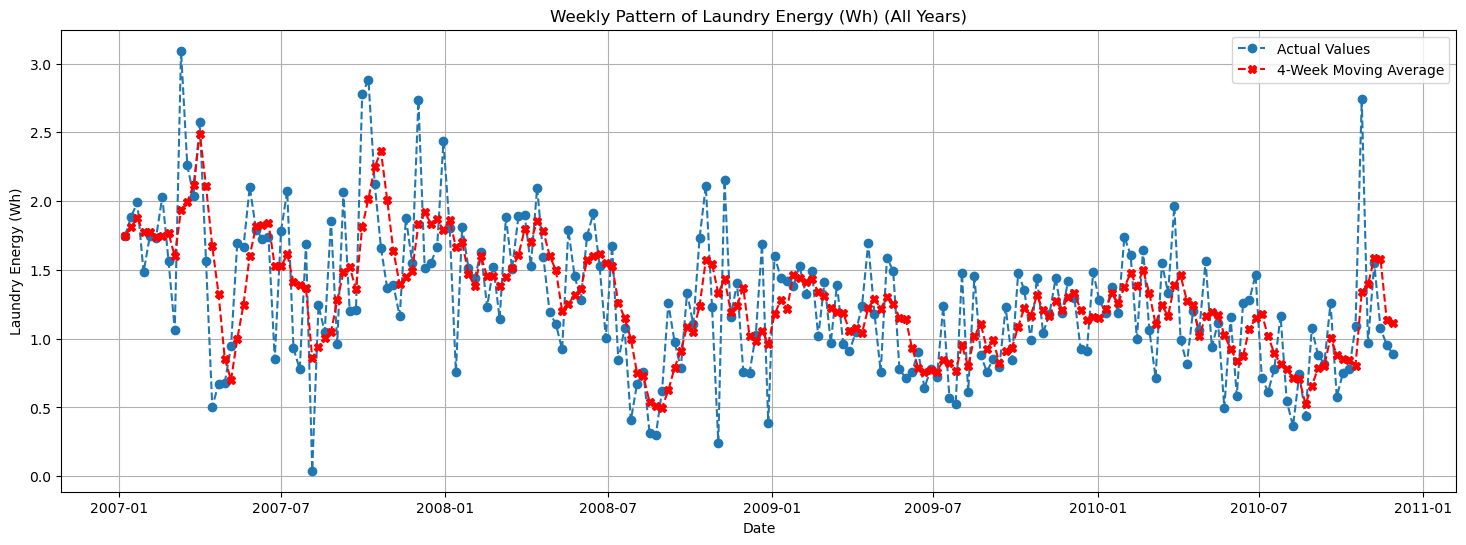

In [35]:
# Ploting weekly pattern with moving average
plot_weekly_pattern(data, 'Laundry Energy (Wh)', window_size=4)

The graph presents the weekly laundry energy usage in watt-hours (Wh) alongside a 4-week moving average over multiple years:

1. **Weekly Fluctuations:** There's a pronounced variability in weekly energy usage, which is typical given the nature of laundry activities that may not follow a strict routine.

2. **4-Week Moving Average:** The moving average moderates these fluctuations, indicating the more consistent trend of laundry energy consumption over time.

3. **Steady Consumption:** Despite the weekly variations, the moving average suggests that laundry energy consumption remains relatively steady without significant long-term increases or decreases.

4. **Seasonal Impact:** Some periodic patterns may be discernible, although less pronounced than with other utilities, suggesting that laundry habits might be influenced by seasonality but also by other factors.

5. **Data Outliers:** The actual values show several spikes which could be due to increased laundry activity in certain weeks or possible data recording errors.

This information could be utilized for planning energy supply, designing energy-saving initiatives in the home, and understanding consumer behavior for utility companies.

Seasonal Data:
DateTime
2006-12-31    2.214987
2007-01-31    1.775931
2007-02-28    1.602361
2007-03-31    2.346872
2007-04-30    0.973149
Freq: M, Name: Laundry Energy (Wh), dtype: float64

Seasonal Moving Average:
DateTime
2006-12-31    2.214987
2007-01-31    1.995459
2007-02-28    1.864426
2007-03-31    1.985038
2007-04-30    1.674578
Freq: M, Name: Laundry Energy (Wh), dtype: float64


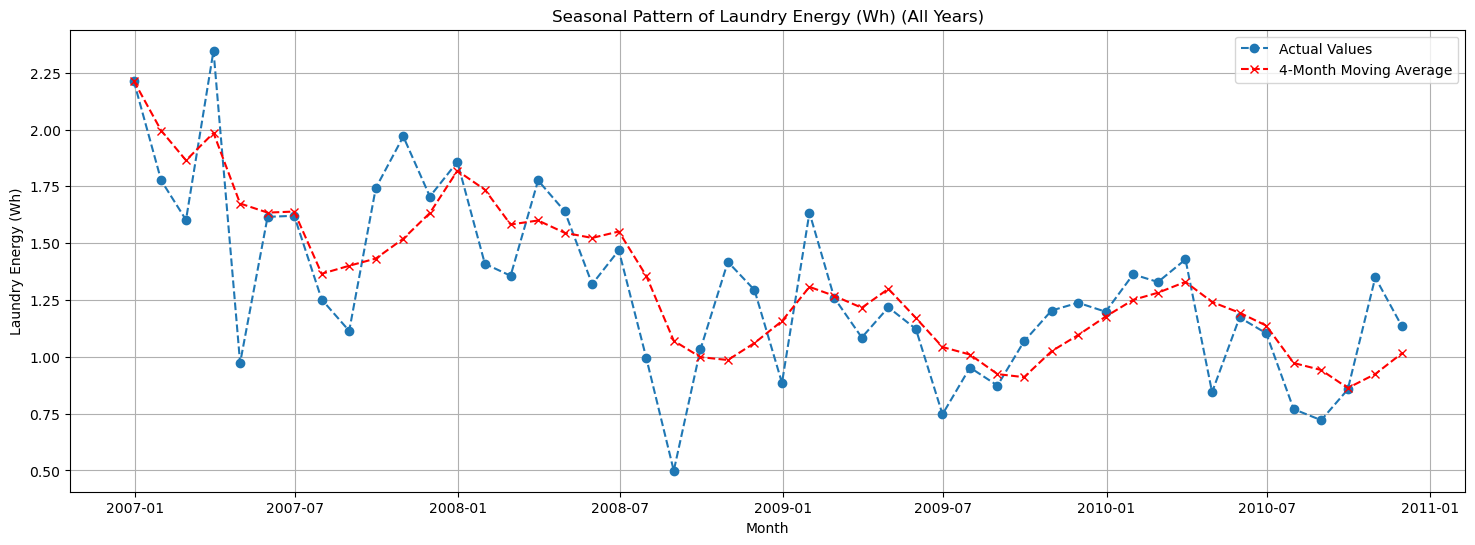

In [36]:
# Ploting seasonal pattern with moving average
plot_seasonal_pattern(data, 'Laundry Energy (Wh)', window_size=4)

This graph illustrates the seasonal pattern of laundry energy usage in watt-hours (Wh) across multiple years.

1. **Seasonal Fluctuations:** Both the actual values and the 4-month moving average reveal clear seasonal trends with peaks and troughs throughout the years.

2. **4-Month Moving Average Trend:** The moving average smooths short-term variations and helps to highlight the more consistent seasonal usage pattern.

3. **Interannual Variability:** There is noticeable year-to-year variability in energy usage, which could reflect changes in household habits, varying numbers of occupants, or different weather patterns affecting the frequency of laundry.

4. **Mid-Year Peaks:** There are typically higher values around the middle of the year, which might coincide with increased laundry due to more outdoor activities or possibly higher occupancy rates (e.g., school breaks).

5. **End-of-Year Patterns:** There’s also an end-of-year increase in usage, which might relate to colder weather requiring more frequent washing of heavier clothing.

Understanding these patterns is crucial for utility companies in planning energy production and distribution, and for consumers aiming to optimize their energy usage.

### Water Heater & AC Energy (Wh)

Weekly Data:
DateTime
2007-01-07    5.376290
2007-01-14    8.270265
2007-01-21    8.086508
2007-01-28    7.149717
2007-02-04    9.448810
Freq: W-SUN, Name: Water Heater & AC Energy (Wh), dtype: float64

Weekly Moving Average:
DateTime
2007-01-07    5.376290
2007-01-14    6.823277
2007-01-21    7.244354
2007-01-28    7.220695
2007-02-04    8.238825
Freq: W-SUN, Name: Water Heater & AC Energy (Wh), dtype: float64


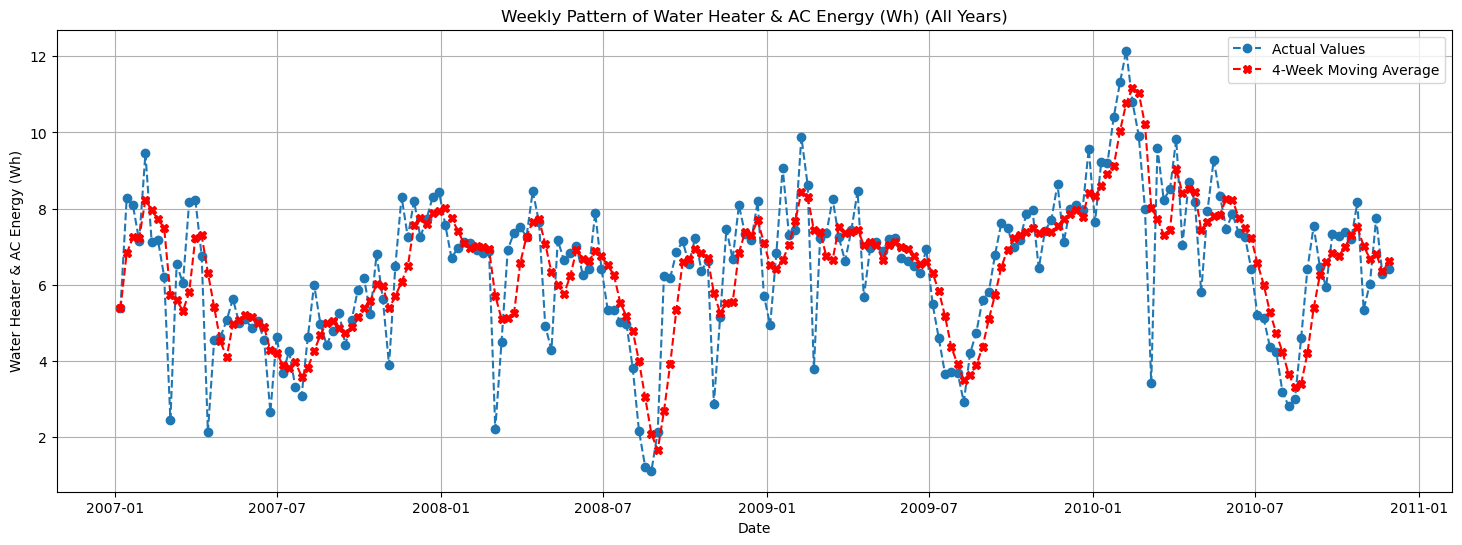

In [37]:
# Ploting weekly pattern with moving average
plot_weekly_pattern(data, 'Water Heater & AC Energy (Wh)', window_size=4)

The graph shows the weekly energy usage for water heaters and air conditioning (AC) in watt-hours (Wh) over several years, accompanied by a 4-week moving average.

1. **Weekly Variability:** There is noticeable weekly variation in energy consumption, indicating that usage is influenced by immediate factors like weather changes, which affect heating and cooling needs.

2. **4-Week Moving Average:** The moving average line smooths out the abrupt changes, presenting a clearer trend that highlights the general pattern in energy usage over the weekly data.

3. **Seasonal Peaks and Valleys:** The moving average displays a pattern of seasonal peaks, likely corresponding with extreme temperatures in summer and winter, and valleys possibly during milder spring and fall months.

4. **Trend Stability:** Despite the weekly fluctuations, the moving average suggests a relatively stable cyclical pattern across the years, with no significant long-term increase or decrease in energy consumption.

5. **Data Outliers:** There are some spikes in the actual values which could be outliers or specific weeks with unusually high usage.

The visualization underscores the importance of seasonal and weekly planning for energy management and can inform strategies for optimizing energy consumption, particularly in heating and cooling applications.

Seasonal Data:
DateTime
2006-12-31    7.409558
2007-01-31    7.383351
2007-02-28    6.703557
2007-03-31    6.504648
2007-04-30    4.800339
Freq: M, Name: Water Heater & AC Energy (Wh), dtype: float64

Seasonal Moving Average:
DateTime
2006-12-31    7.409558
2007-01-31    7.396454
2007-02-28    7.165488
2007-03-31    7.000278
2007-04-30    6.347974
Freq: M, Name: Water Heater & AC Energy (Wh), dtype: float64


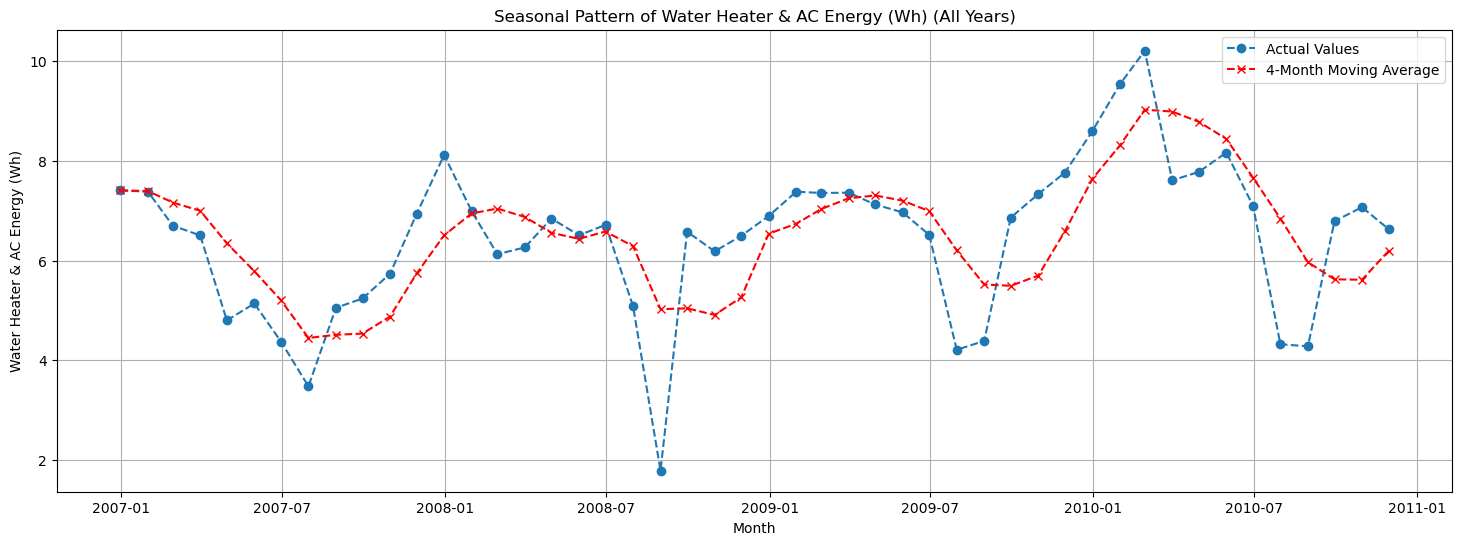

In [38]:
# Ploting seasonal pattern with moving average
plot_seasonal_pattern(data, 'Water Heater & AC Energy (Wh)', window_size=4)

The graph displays the seasonal pattern of energy consumption for water heaters and air conditioners (AC) in watt-hours (Wh), comparing actual values with a 4-month moving average:

1. **Seasonal Trends:** There are clear seasonal trends with peaks during summer and winter, corresponding with the increased use of AC during hot months and water heaters during cold months.

2. **4-Month Moving Average:** The moving average smooths short-term fluctuations, emphasizing the underlying seasonal trends and providing a clearer picture of long-term consumption patterns.

3. **Consistent Seasonal Peaks:** The consistency of peaks around the same time each year suggests a strong correlation between energy usage and seasonal temperatures.

4. **Mid-Year Dips:** There are dips typically around the transition between seasons, reflecting a possible reduced need for heating and cooling.

5. **Yearly Comparison:** Comparing the moving average over the years, we can see a relatively consistent pattern, which can be helpful for predicting future energy needs and planning accordingly. 

This graph can help in energy planning and optimizing the use of water heaters and AC systems for efficiency.

In [39]:
def bias(actual, predicted):
    return np.mean(predicted - actual)

def mean_absolute_error(actual, predicted):
    return np.mean(np.abs(predicted - actual))

def root_mean_squared_error(actual, predicted):
    return np.sqrt(np.mean((predicted - actual)**2))

def mean_squared_error(actual, predicted):
    return np.mean((predicted - actual)**2)

def mean_absolute_percentage_error(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100


In [40]:
actual_values = data['Active Power (kW)'].resample('W').mean()
predicted_values = data['Active Power (kW)'].rolling(window=4).mean()

# Removing NaN values
actual_values = actual_values.dropna()
predicted_values = predicted_values.dropna()

# Calculating metrics
bias_value = bias(actual_values, predicted_values)
mae_value = mean_absolute_error(actual_values, predicted_values)
rmse_value = root_mean_squared_error(actual_values, predicted_values)
mse_value = mean_squared_error(actual_values, predicted_values)
mape_value = mean_absolute_percentage_error(actual_values, predicted_values)

print("Bias:", round(bias_value,2))
print("MAE:", round(mae_value,2))
print("RMSE:", round(rmse_value,2))
print("MSE:", round(mse_value,2))
print("MAPE:", round(mape_value,2))

Bias: 0.17
MAE: 0.74
RMSE: 0.99
MSE: 0.99
MAPE: 66.64


In [41]:
actual_values = data['Active Power (kW)'].resample('M').mean()
predicted_values = data['Active Power (kW)'].rolling(window=4).mean()


actual_values = actual_values.dropna()
predicted_values = predicted_values.dropna()


bias_value = bias(actual_values, predicted_values)
mae_value = mean_absolute_error(actual_values, predicted_values)
rmse_value = root_mean_squared_error(actual_values, predicted_values)
mse_value = mean_squared_error(actual_values, predicted_values)
mape_value = mean_absolute_percentage_error(actual_values, predicted_values)

print("Bias:", round(bias_value,2))
print("MAE:", round(mae_value,2))
print("RMSE:", round(rmse_value,2))
print("MSE:", round(mse_value,2))
print("MAPE:", round(mape_value,2))

Bias: -0.4
MAE: 0.72
RMSE: 0.79
MSE: 0.62
MAPE: 64.69


## Exponential Smoothing

### Single Exponential Smoothing (SES)

MAE (Weekly): 0.21
MSE (Weekly): 0.07
RMSE (Weekly): 0.26


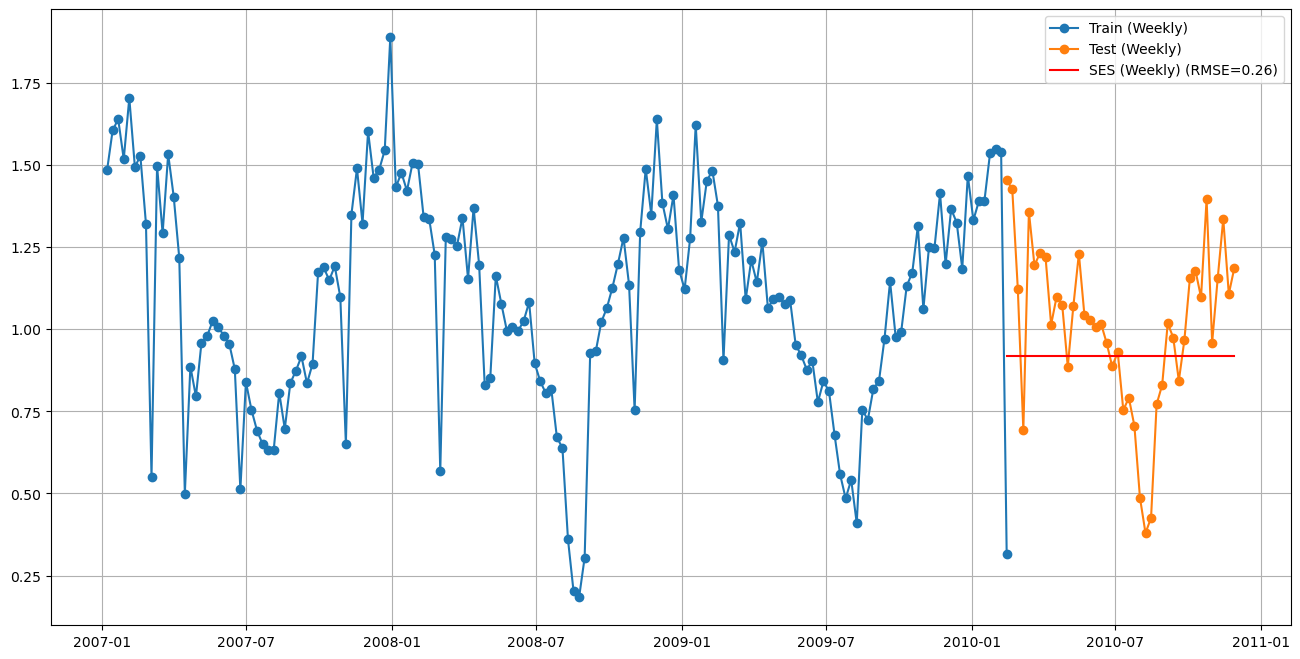

In [42]:
data = data[data.index.year != 2006]
# Spliting data into train and test
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Resampling data to weekly frequency and interpolate missing values
train_data_weekly = train_data['Active Power (kW)'].resample('W').mean().interpolate()
test_data_weekly = test_data['Active Power (kW)'].resample('W').mean().interpolate()

# Fitting the SES model
ses_model_weekly = SimpleExpSmoothing(np.asarray(train_data_weekly))
ses_fit_weekly = ses_model_weekly.fit(smoothing_level=0.5, optimized=False)

# Making predictions
predictions_weekly = ses_fit_weekly.forecast(len(test_data_weekly))

# Calculating KPIs
mae_weekly = mean_absolute_error(test_data_weekly, predictions_weekly)
mse_weekly = mean_squared_error(test_data_weekly, predictions_weekly)
rmse_weekly = sqrt(mse_weekly)

print("MAE (Weekly): {:.2f}".format(mae_weekly))
print("MSE (Weekly): {:.2f}".format(mse_weekly))
print("RMSE (Weekly): {:.2f}".format(rmse_weekly))

# Plotting the graphs
plt.figure(figsize=(16, 8))
plt.plot(train_data_weekly, label='Train (Weekly)', marker='o', linestyle='-')
plt.plot(test_data_weekly, label='Test (Weekly)', marker='o', linestyle='-')
plt.plot(test_data_weekly.index, predictions_weekly, label='SES (Weekly) (RMSE={:.2f})'.format(rmse_weekly)
         , linestyle='-', color = 'red')
plt.legend()
plt.grid(True)
plt.show()


This graph displays the actual weekly power consumption data separated into training and test datasets, along with a Simple Exponential Smoothing (SES) forecast:

1. **Training Data (Blue):** The training dataset, shown in blue, indicates the historical weekly power consumption that the SES model learns from.

2. **Test Data (Orange):** The test dataset, shown in orange, represents the out-of-sample data that the SES model attempts to forecast.

3. **SES Forecast (Red Line):** The SES model provides a constant forecast (horizontal red line), which is the simple average of the data weighted by the exponential smoothing factor. It doesn't adapt to changes over time, hence the flat nature.

4. **RMSE Value:** The Root Mean Square Error (RMSE) of 0.26 on the forecast indicates the average deviation of the forecasted values from the actual values in the test dataset; a lower RMSE is generally better.

5. **Inference:** The SES model's constant value doesn't capture the fluctuations of the actual data, suggesting it may not be the best model for this dataset, which clearly shows seasonality and trend that the SES model doesn't account for. A model that can capture the seasonal and trend components, such as Holt-Winters exponential smoothing or ARIMA, might provide a better fit.

MAE (Monthly): 0.46
MSE (Monthly): 0.26
RMSE (Monthly): 0.51


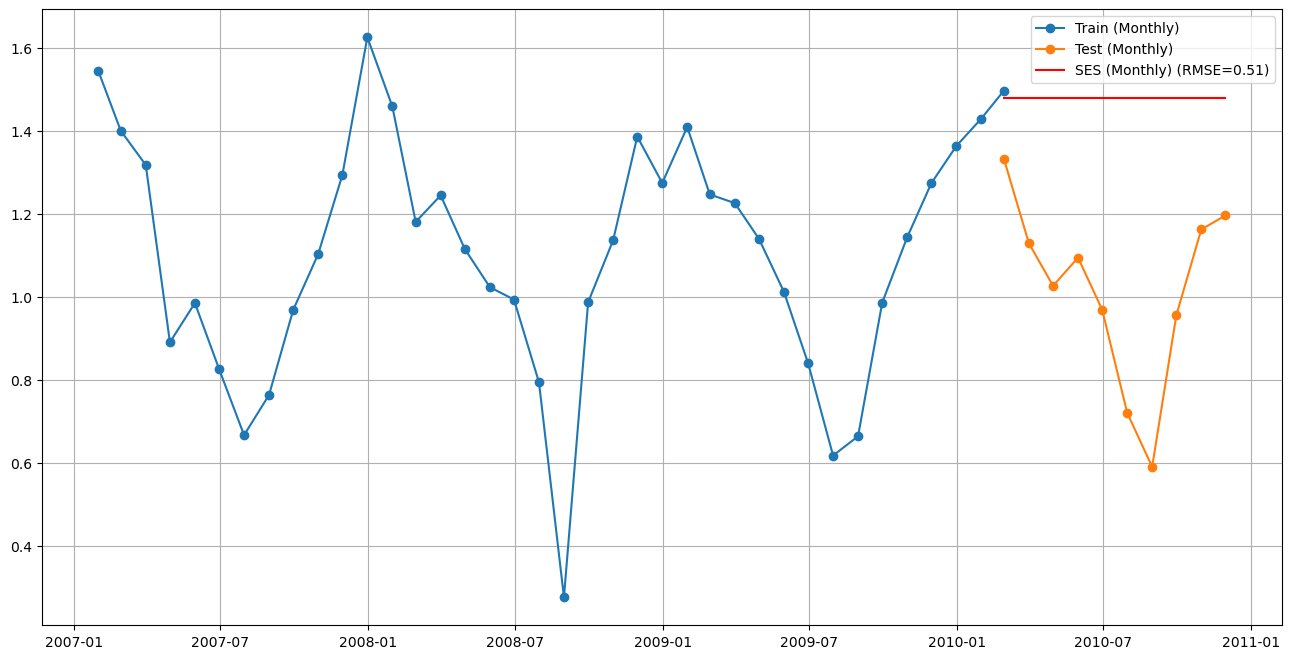

In [43]:
# Resampling data to monthly frequency and interpolate missing values
train_data_monthly = train_data['Active Power (kW)'].resample('M').mean().interpolate()
test_data_monthly = test_data['Active Power (kW)'].resample('M').mean().interpolate()

# Fitting the SES model
ses_model_monthly = SimpleExpSmoothing(np.asarray(train_data_monthly))
ses_fit_monthly = ses_model_monthly.fit(smoothing_level=0.8, optimized=False)

# Making predictions
predictions_monthly = ses_fit_monthly.forecast(len(test_data_monthly))

# Calculating KPIs
mae_monthly = mean_absolute_error(test_data_monthly, predictions_monthly)
mse_monthly = mean_squared_error(test_data_monthly, predictions_monthly)
rmse_monthly = sqrt(mse_monthly)

print("MAE (Monthly): {:.2f}".format(mae_monthly))
print("MSE (Monthly): {:.2f}".format(mse_monthly))
print("RMSE (Monthly): {:.2f}".format(rmse_monthly))

# Plotting 
plt.figure(figsize=(16, 8))
plt.plot(train_data_monthly, label='Train (Monthly)', marker='o', linestyle='-')
plt.plot(test_data_monthly, label='Test (Monthly)', marker='o', linestyle='-')
plt.plot(test_data_monthly.index, predictions_monthly, label='SES (Monthly) (RMSE={:.2f})'.format(rmse_monthly)
         , linestyle='-', color = 'red')
plt.legend()
plt.grid(True)
plt.show()


In this graph, we see monthly active power consumption data:

1. **Training Data (Blue):** Historical data used to train the Simple Exponential Smoothing (SES) model, showing monthly active power consumption over several years.

2. **Test Data (Orange):** More recent data not used in training the model, used to evaluate the model's forecasting performance.

3. **SES Forecast (Red Line):** The red horizontal line represents the SES forecast. This model provides a single forecast value extended into the future, reflecting the model's assumption of the data's level without considering trend or seasonality.

4. **RMSE Value (0.51):** The RMSE score measures the average magnitude of the forecast errors. An RMSE of 0.51 for the SES model indicates moderate forecasting error, suggesting that the model's forecasts are, on average, 0.51 units from the actual monthly consumption values.

5. **Inference:** The SES model's horizontal line indicates that it does not adapt to the clear seasonality and trend present in the data. It assumes consumption will continue at a constant rate equal to the historical average, which does not seem to be a good fit for this dataset. A model that includes components to handle trends and seasonal changes would likely perform better.

### Double Exponential Smoothing (DES)

C:\Users\kalya\anaconda3\lib\site-packages\pandas\util\_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


MAE (Holt Linear): 0.20
MSE (Holt Linear): 0.07
RMSE (Holt Linear): 0.26


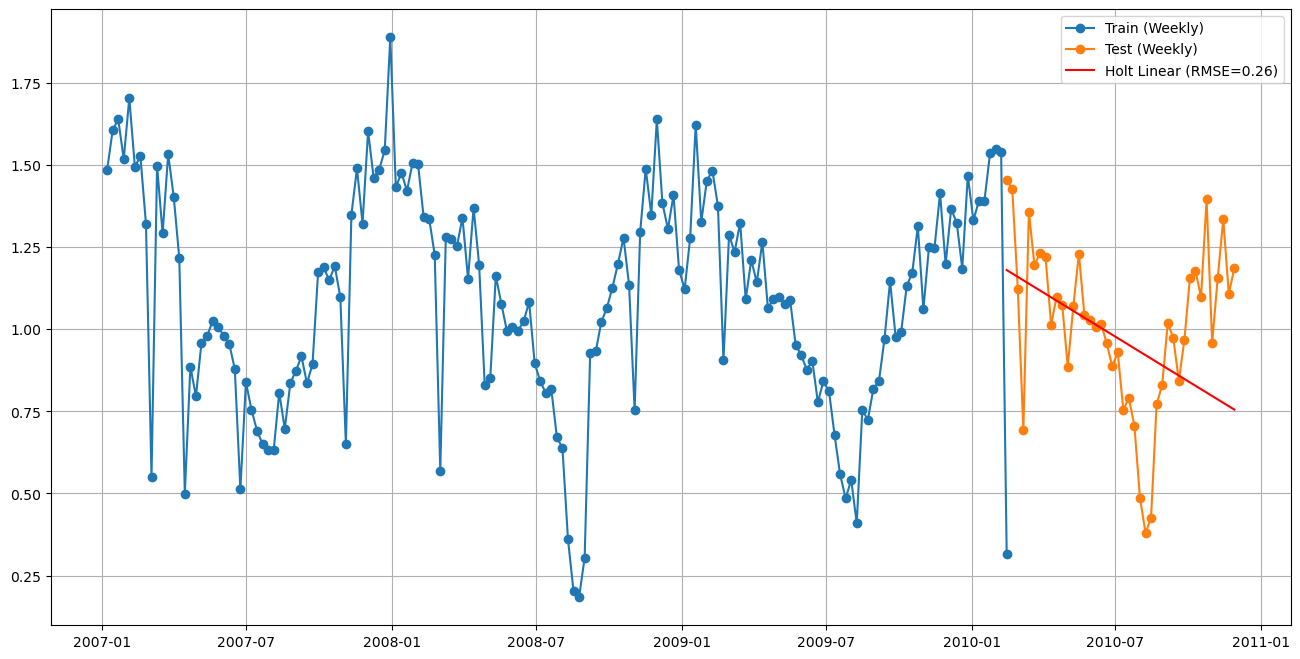

In [70]:
# Resample data to weekly frequency and interpolate missing values
train_data_weekly = train_data['Active Power (kW)'].resample('W').mean().interpolate()
test_data_weekly = test_data['Active Power (kW)'].resample('W').mean().interpolate()

# Fit the Holt linear model
fit1 = Holt(np.asarray(train_data_weekly)).fit(smoothing_level=0.3, smoothing_slope=0.1)

# Make predictions
predictions_holt_linear = fit1.forecast(len(test_data_weekly))

# Calculate KPIs
mae_holt_linear = mean_absolute_error(test_data_weekly, predictions_holt_linear)
mse_holt_linear = mean_squared_error(test_data_weekly, predictions_holt_linear)
rmse_holt_linear = sqrt(mse_holt_linear)

print("MAE (Holt Linear): {:.2f}".format(mae_holt_linear))
print("MSE (Holt Linear): {:.2f}".format(mse_holt_linear))
print("RMSE (Holt Linear): {:.2f}".format(rmse_holt_linear))

# Plot
plt.figure(figsize=(16, 8))
plt.plot(train_data_weekly, label='Train (Weekly)',marker='o', linestyle='-')
plt.plot(test_data_weekly, label='Test (Weekly)', marker='o', linestyle='-')
plt.plot(test_data_weekly.index, predictions_holt_linear, label='Holt Linear (RMSE={:.2f})'.format(rmse_holt_linear),
        linestyle='-', color = 'red')
plt.legend()
plt.grid(True)
plt.show()


This chart depicts the weekly active power (kW) consumption data along with a trend line from the Holt’s Linear Trend method:

1. **Training Data (Blue):** This is the historical data on which the Holt’s Linear Trend model has been trained. It spans several years and shows the weekly active power consumption.

2. **Test Data (Orange):** This set of data is used to test the model's performance. It represents the most recent data points not seen by the model during training.

3. **Holt’s Linear Trend Forecast (Red Line):** Unlike the Simple Exponential Smoothing model, Holt’s Linear Trend model incorporates information about the trend of the data. The red line represents the model's attempt to forecast future values based on the underlying trend it has detected in the historical data.

4. **RMSE Value (0.26):** The Root Mean Square Error (RMSE) is a measure of the model's forecast error magnitude, with a lower value indicating a better fit. An RMSE of 0.26 indicates that, on average, the model’s predictions are 0.26 units away from the actual values, which suggests that the model is reasonably accurate.

5. **Inference:** The model’s forecast line (red) indicates a downward trend in the latter part of the test data, which suggests that the model has detected a decreasing trend in the active power consumption. However, the test data seems to be more volatile, which could mean that the model might not capture all the complexities of the data, such as seasonal fluctuations or irregular patterns.

MAE (Holt Linear): 0.20
MSE (Holt Linear): 0.07
RMSE (Holt Linear): 0.26


C:\Users\kalya\anaconda3\lib\site-packages\pandas\util\_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


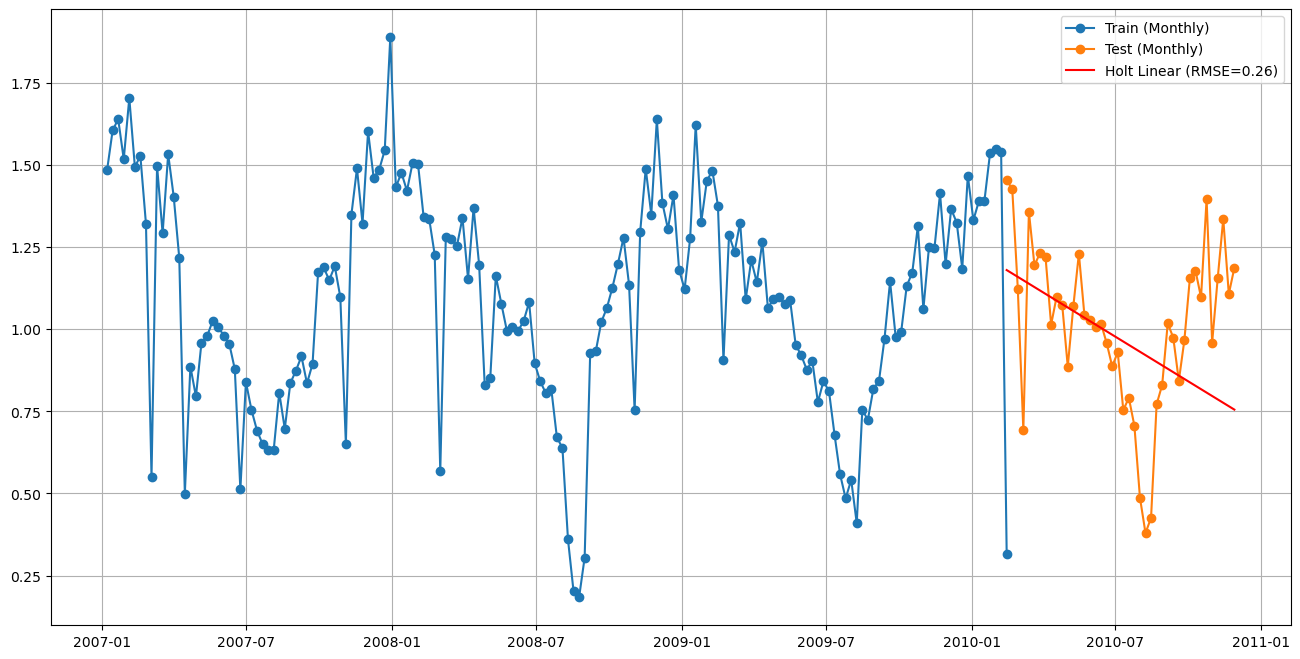

In [45]:
# Resample data to monthly frequency and interpolate missing values
train_data_monthly = train_data['Active Power (kW)'].resample('W').mean().interpolate()
test_data_monthly = test_data['Active Power (kW)'].resample('W').mean().interpolate()

# Fit the Holt linear model
fit1 = Holt(np.asarray(train_data_monthly)).fit(smoothing_level=0.3, smoothing_slope=0.1)

# Make predictions
predictions_holt_linear = fit1.forecast(len(test_data_monthly))

# Calculate KPIs
mae_holt_linear = mean_absolute_error(test_data_monthly, predictions_holt_linear)
mse_holt_linear = mean_squared_error(test_data_monthly, predictions_holt_linear)
rmse_holt_linear = sqrt(mse_holt_linear)

print("MAE (Holt Linear): {:.2f}".format(mae_holt_linear))
print("MSE (Holt Linear): {:.2f}".format(mse_holt_linear))
print("RMSE (Holt Linear): {:.2f}".format(rmse_holt_linear))

# Plot
plt.figure(figsize=(16, 8))
plt.plot(train_data_monthly, label='Train (Monthly)',marker='o', linestyle='-')
plt.plot(test_data_monthly, label='Test (Monthly)', marker='o', linestyle='-')
plt.plot(test_data_monthly.index, predictions_holt_linear, label='Holt Linear (RMSE={:.2f})'.format(rmse_holt_linear),
        linestyle='-', color = 'red')
plt.legend()
plt.grid(True)
plt.show()


The graph displays monthly active power (kW) consumption data alongside a Holt's Linear Trend model:

1. **Training Data (Blue):** Shows historical monthly active power consumption used to train the Holt's Linear model, indicating the overall variability and trend in power usage.

2. **Test Data (Orange):** These are the more recent data points used to validate the model's predictive performance, representing unseen data during the training phase.

3. **Holt’s Linear Trend Line (Red):** This model accounts for both the level and the trend of the dataset, which the red line indicates. The line represents the model's attempt to forecast future values considering the trend in the data.

4. **RMSE (Root Mean Square Error) Value (0.26):** This metric quantifies the average magnitude of the errors between the predicted values by the model and the actual data. An RMSE of 0.26 suggests the model has a relatively good fit to the data, with predictions deviating from actual values by an average of 0.26 kW.

5. **Inference:** The red trend line shows that the model predicts a decreasing trend in active power usage toward the end of the test period. However, the model does not capture all fluctuations, particularly the volatile peaks and troughs in power consumption. This could mean that while the trend is generally downward, the model may not fully account for seasonal variations or other factors affecting power usage.

### Triple Exponential Smoothing (TES)

MAE (Holt Winter): 0.28
MSE (Holt Winter): 0.11
RMSE (Holt Winter): 0.33


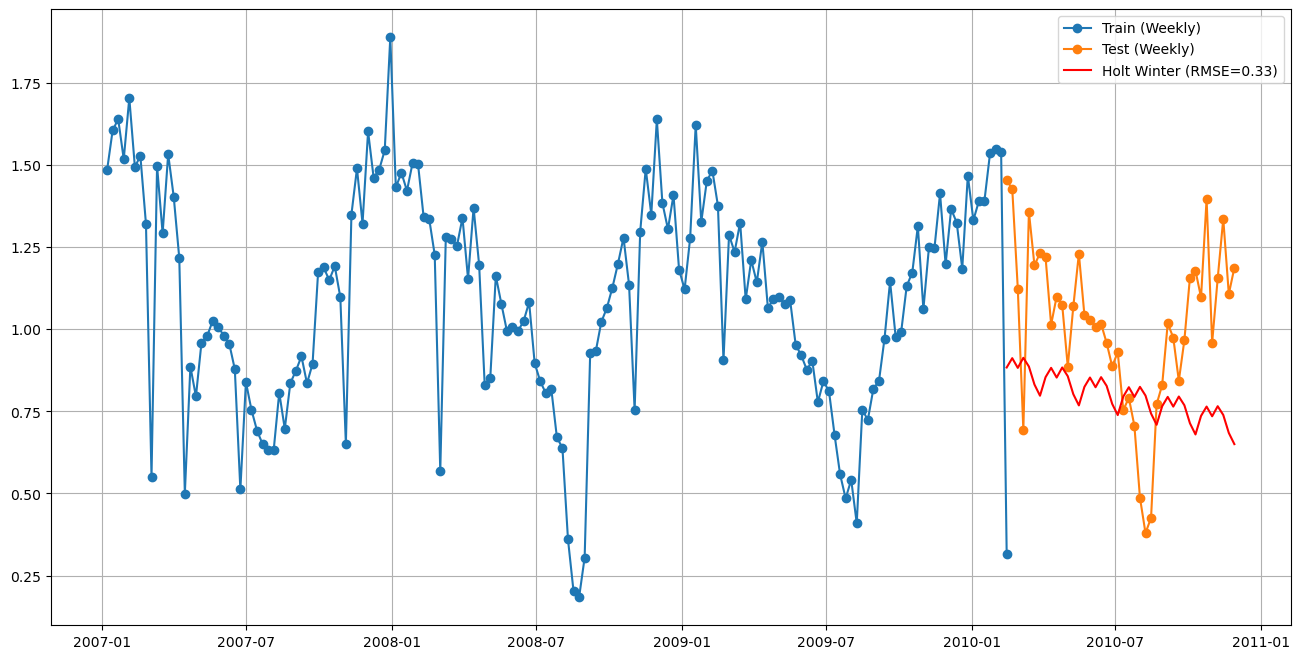

In [72]:
# Fit the Holt-Winters model
fit1 = ExponentialSmoothing(np.asarray(train_data_weekly), seasonal_periods=7, trend='add', seasonal='add').fit()

# Make predictions
predictions_holt_winter = fit1.forecast(len(test_data_weekly))

# Calculate KPIs
mae_holt_winter = mean_absolute_error(test_data_weekly, predictions_holt_winter)
mse_holt_winter = mean_squared_error(test_data_weekly, predictions_holt_winter)
rmse_holt_winter = sqrt(mse_holt_winter)

print("MAE (Holt Winter): {:.2f}".format(mae_holt_winter))
print("MSE (Holt Winter): {:.2f}".format(mse_holt_winter))
print("RMSE (Holt Winter): {:.2f}".format(rmse_holt_winter))

# Plot
plt.figure(figsize=(16, 8))
plt.plot(train_data_weekly, label='Train (Weekly)',marker='o', linestyle='-')
plt.plot(test_data_weekly, label='Test (Weekly)', marker='o', linestyle='-')
plt.plot(test_data_weekly.index, predictions_holt_winter, label='Holt Winter (RMSE={:.2f})'.format(rmse_holt_winter),
        linestyle='-', color = 'red')
plt.legend()
plt.grid(True)
plt.show()

This graph illustrates weekly active power (kW) consumption with a Holt-Winters seasonal method applied:

1. **Training Data (Blue):** Represents historical weekly active power consumption data used to train the model. This data helps to capture the baseline level, trend, and seasonal patterns.

2. **Test Data (Orange):** This set comprises the recent data points not seen by the model during training. It is used to evaluate how well the model can forecast future values.

3. **Holt-Winters Forecast (Red Line):** This line represents the model's predictions, which account for trend and seasonality. The Holt-Winters method is particularly suited for data with a known seasonal pattern.

4. **RMSE (Root Mean Square Error) Value (0.33):** Indicates the model's average prediction error, suggesting how closely the forecasted values align with the actual data. An RMSE value of 0.33 for a weekly power consumption model is fairly moderate, meaning the predictions are relatively close to the actual data but there is room for improvement.

5. **Inference:** The forecast line appears to follow the overall trend and seasonal variations of the actual data, suggesting that the model captures these patterns to some extent. However, the model's forecast towards the end of the period deviates from the test data, indicating potential overfitting to the training data or changes in the pattern not accounted for by the model. The increasing gap between the forecast and actual values could also mean that the model's parameters may need re-evaluation to better fit more recent trends or external factors influencing power consumption.

MAE (Holt Winter): 0.35
MSE (Holt Winter): 0.16
RMSE (Holt Winter): 0.40


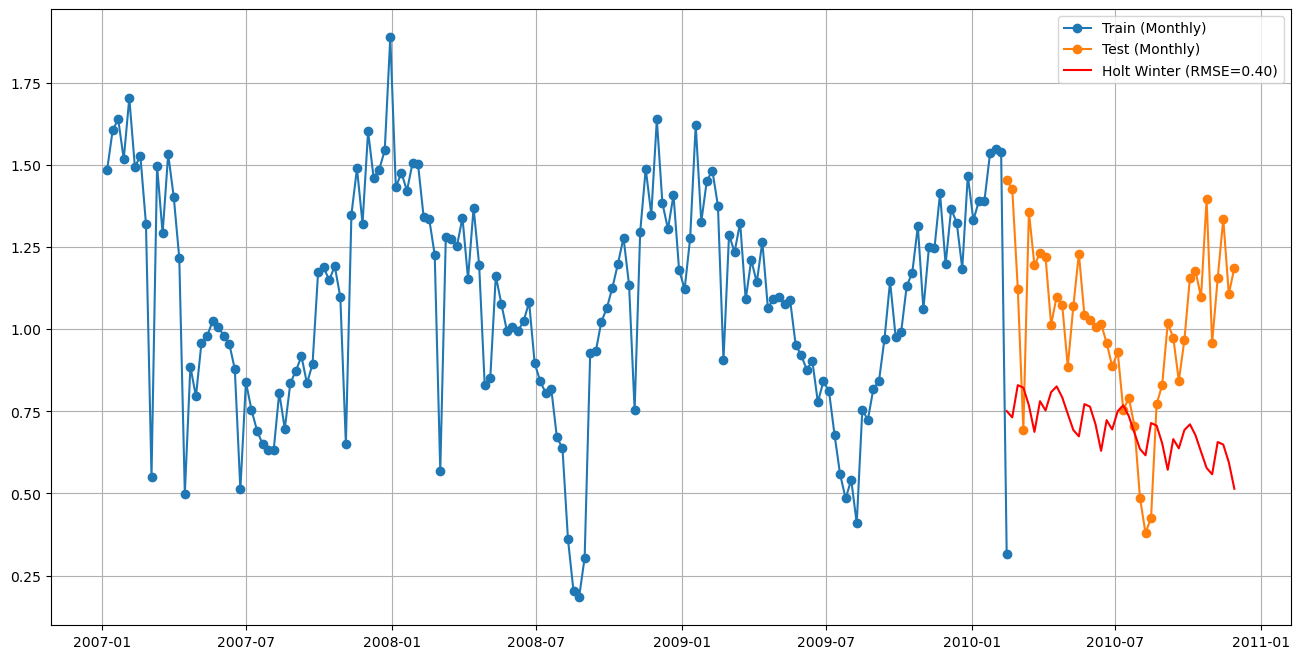

In [71]:
# Fit the Holt-Winters model
fit1 = ExponentialSmoothing(np.asarray(train_data_monthly), seasonal_periods=12, trend='add', seasonal='add').fit()

# Make predictions
predictions_holt_winter = fit1.forecast(len(test_data_monthly))

# Calculate KPIs
mae_holt_winter = mean_absolute_error(test_data_monthly, predictions_holt_winter)
mse_holt_winter = mean_squared_error(test_data_monthly, predictions_holt_winter)
rmse_holt_winter = sqrt(mse_holt_winter)

print("MAE (Holt Winter): {:.2f}".format(mae_holt_winter))
print("MSE (Holt Winter): {:.2f}".format(mse_holt_winter))
print("RMSE (Holt Winter): {:.2f}".format(rmse_holt_winter))

# Plot
plt.figure(figsize=(16, 8))
plt.plot(train_data_monthly, label='Train (Monthly)',marker='o', linestyle='-')
plt.plot(test_data_monthly, label='Test (Monthly)', marker='o', linestyle='-')
plt.plot(test_data_monthly.index, predictions_holt_winter, label='Holt Winter (RMSE={:.2f})'.format(rmse_holt_winter),
        linestyle='-', color = 'red')
plt.legend()
plt.grid(True)
plt.show()

The graph represents the time series analysis of energy consumption using the Holt-Winters forecasting method:

1. **Training Data (Blue):** This is historical monthly data used to train the Holt-Winters model. The dense blue dots show the actual energy consumed each month during the training phase.

2. **Test Data (Orange):** These are actual consumption values not included in the training set and are used to validate the model's performance. The spread of the orange dots represents the actual energy consumed each month during the test phase.

3. **Holt-Winters Forecast (Red Line):** This line represents the model's predictions, which incorporate the trend and seasonal patterns observed in the training data. The Holt-Winters method adjusts for both seasonality and trend, making it well-suited for time series data with a periodic structure.

4. **RMSE (Root Mean Square Error) Value (0.40):** This value is a measure of the model's forecast accuracy. It represents the average magnitude of the errors between the predicted and actual values. An RMSE of 0.40 indicates that the model's predictions are, on average, within 0.40 units of the actual energy consumption values.

5. **Inference:** The red forecast line starts to deviate significantly from the test data towards the end of the series, indicating potential overfitting to historical patterns or a change in the pattern that the model did not anticipate. The rising RMSE value suggests that model accuracy is decreasing over time, and the model may need to be re-evaluated or updated with more recent data. It's also possible that new factors influencing energy consumption have emerged, which the model has not accounted for.

## Linear Regression

MAE: 0.37
MSE: 0.30
RMSE: 0.55


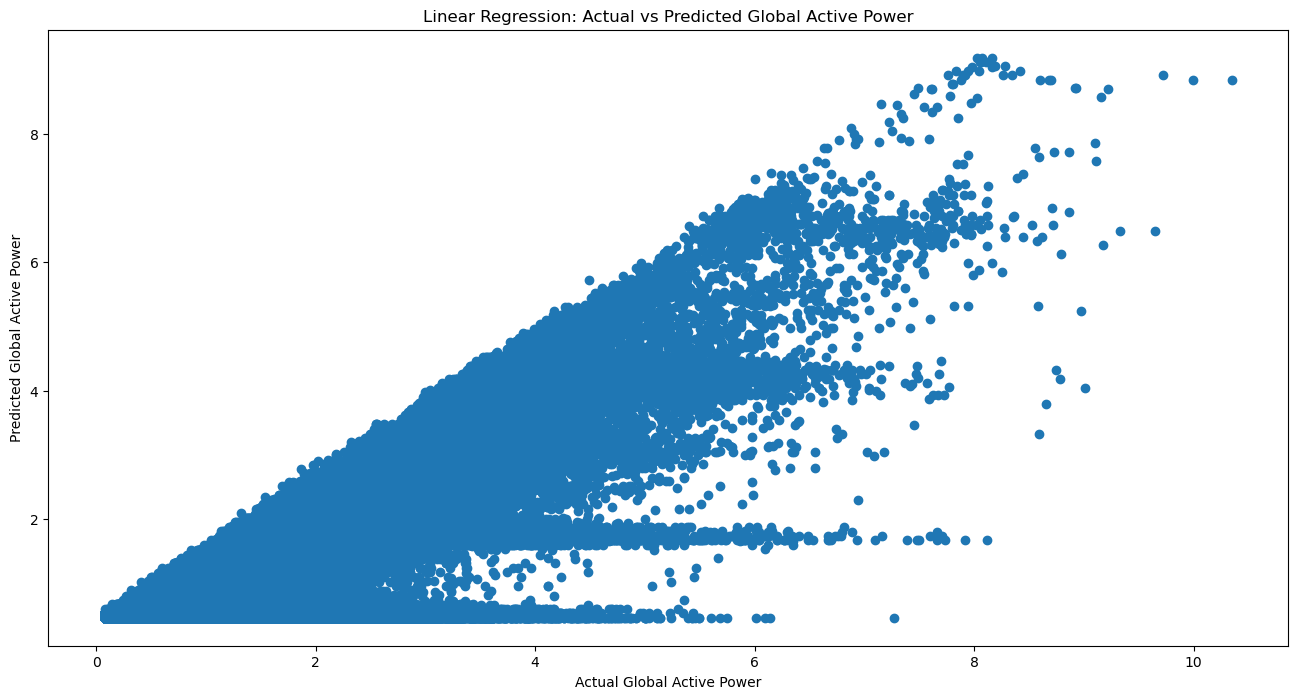

In [48]:
# Split data into features (X) and target variable (y)
X = data[['Kitchen Energy (Wh)', 'Laundry Energy (Wh)', 'Water Heater & AC Energy (Wh)']]
y = data['Active Power (kW)']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate KPIs
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

print("MAE: {:.2f}".format(mae))
print("MSE: {:.2f}".format(mse))
print("RMSE: {:.2f}".format(rmse))

# Plot
plt.figure(figsize=(16, 8))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Global Active Power')
plt.ylabel('Predicted Global Active Power')
plt.title('Linear Regression: Actual vs Predicted Global Active Power')
plt.show()


The above scatter plot compares the actual versus predicted values from a linear regression model for Global Active Power:

- **X-axis (Actual Global Active Power):** Represents the true values observed or measured in the data.
- **Y-axis (Predicted Global Active Power):** Represents the values predicted by the linear regression model.

**Inference:**

1. **Linear Relationship**: The scatter plot suggests that there is a positive linear relationship between the actual and predicted values, which implies that the model is able to predict higher values of active power with some degree of accuracy.

2. **Prediction Accuracy**: The data points are scattered around a line that would represent a perfect prediction. The closer the data points to this hypothetical line, the more accurate the predictions are. The plot shows a wide dispersion of points, especially for higher values of actual power, indicating that the model's predictions are less accurate in these ranges.

3. **Potential Overestimation or Underestimation**: The plot shows that for lower actual values, the model tends to overestimate, and for higher actual values, it tends to underestimate. This is indicated by the concentration of points above the hypothetical perfect prediction line at the lower end and below this line at the higher end.

4. **Outliers or High Variability**: There are several data points that diverge significantly from the main cloud of points, indicating potential outliers or high variability in the data that the linear model may not be capturing well.

5. **Model Fit**: The model seems to fit moderately well for the mid-range of values but not as well for the lower and upper extremes. This could suggest that a non-linear model or a model with more features could potentially improve the prediction accuracy.

## ARIMA

In [49]:
data_2010 = data[data.index.year == 2010]

In [50]:
data_2010.head()

Active Power (kW)  Reactive Power (kW)  Voltage (V)  \
DateTime                                                                   
2010-01-01 00:00:00              1.790                0.236       240.65   
2010-01-01 00:01:00              1.780                0.234       240.07   
2010-01-01 00:02:00              1.780                0.234       240.15   
2010-01-01 00:03:00              1.746                0.186       240.26   
2010-01-01 00:04:00              1.686                0.102       240.12   

                     Current Intensity (A)  Kitchen Energy (Wh)  \
DateTime                                                          
2010-01-01 00:00:00                    7.4                  0.0   
2010-01-01 00:01:00                    7.4                  0.0   
2010-01-01 00:02:00                    7.4                  0.0   
2010-01-01 00:03:00                    7.2                  0.0   
2010-01-01 00:04:00                    7.0                  0.0   

                     Laundry Energy (Wh)  Water Heater & AC Energy (Wh)  Month  
DateTime                                                                        
2010-01-01 00:00:00                  0.0                           18.0      1  
2010-01-01 00:01:00                  0.0                           18.0      1  
2010-01-01 00:02:00                  0.0                           19.0      1  
2010-01-01 00:03:00                  0.0                           18.0      1  
2010-01-01 00:04:00                  0.0                           18.0      1

In [51]:
daily_data = data_2010.resample('D').mean()
# Resetting index to make DateTime a column again
daily_data.reset_index(inplace=True)
# Dropping Month column if you don't need it anymore
daily_data.drop('Month', axis=1, inplace=True)
# Dropping null values from daily_data
daily_data.dropna(inplace=True)
# Setting 'DateTime' column as the index
daily_data.set_index('DateTime', inplace=True)

In [52]:
daily_data.head()

Active Power (kW)  Reactive Power (kW)  Voltage (V)  \
DateTime                                                          
2010-01-01           0.850175             0.114817   242.565722   
2010-01-02           0.909546             0.138580   244.677179   
2010-01-03           1.446843             0.133063   243.744528   
2010-01-04           1.113981             0.108614   245.699118   
2010-01-05           1.541514             0.103428   244.521035   

            Current Intensity (A)  Kitchen Energy (Wh)  Laundry Energy (Wh)  \
DateTime                                                                      
2010-01-01               3.537083             1.600000             0.227083   
2010-01-02               3.813760             0.556637             0.207088   
2010-01-03               6.044167             2.668056             3.416667   
2010-01-04               4.599444             0.000000             0.202778   
2010-01-05               6.347083             1.239583             0.203472   

            Water Heater & AC Energy (Wh)  
DateTime                                   
2010-01-01                       2.470833  
2010-01-02                       4.464211  
2010-01-03                       6.995833  
2010-01-04                       7.508333  
2010-01-05                      11.436111

In [53]:
daily_data.isnull().sum()

Active Power (kW)                0
Reactive Power (kW)              0
Voltage (V)                      0
Current Intensity (A)            0
Kitchen Energy (Wh)              0
Laundry Energy (Wh)              0
Water Heater & AC Energy (Wh)    0
dtype: int64

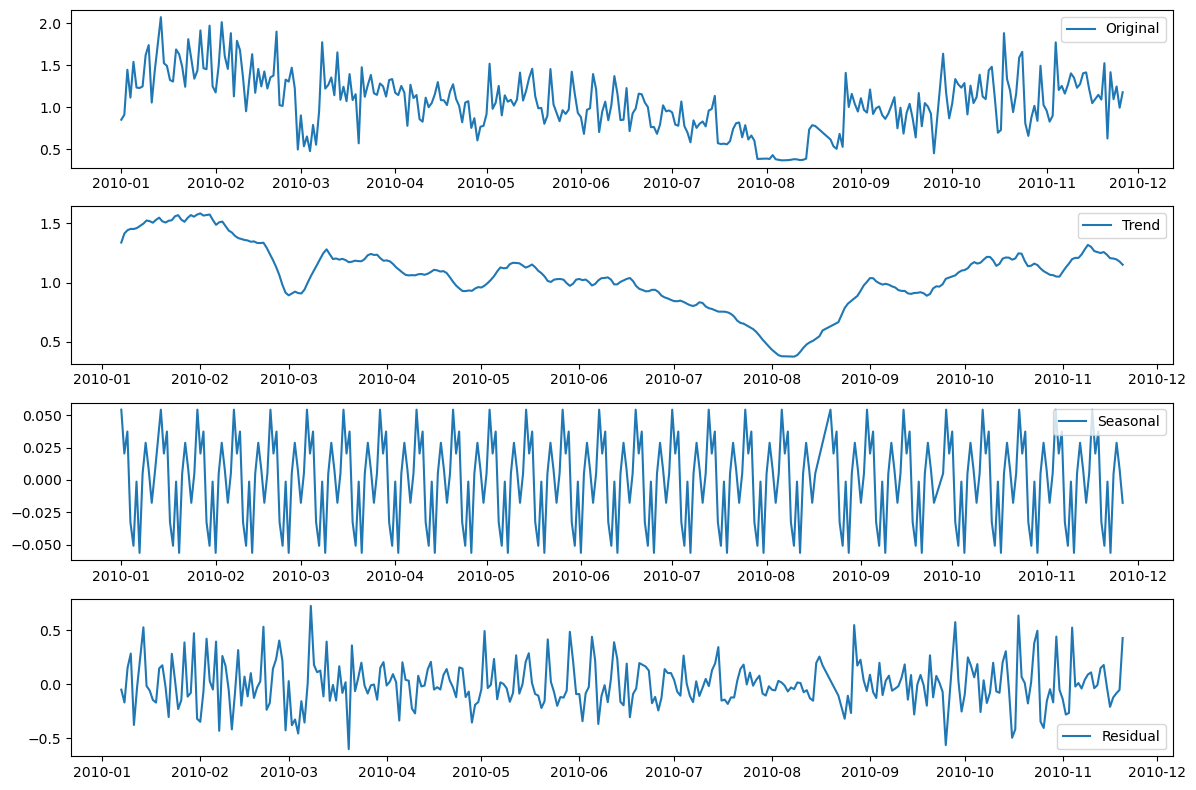

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Performing additive decomposition with period=12
decomp = seasonal_decompose(daily_data['Active Power (kW)'], period=12)

# Plotting decomposition
plt.figure(figsize=(12, 8))

# Plotting the observed data
plt.subplot(411)
plt.plot(decomp.observed, label='Original')
plt.legend()

# Plotting the trend component
plt.subplot(412)
plt.plot(decomp.trend, label='Trend')
plt.legend()

# Plotting the seasonal component
plt.subplot(413)
plt.plot(decomp.seasonal, label='Seasonal')
plt.legend()

# Plotting the residual component
plt.subplot(414)
plt.plot(decomp.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


The charts represent a time series decomposition of data into trend, seasonal, and residual components:

- **Top Chart (Original):** This displays the original time series data. The data appears to be non-stationary, with both trend and seasonal variations present.

- **Second Chart (Trend):** Here, the long-term movement of the series is depicted. The trend shows a slight increase over time until around mid-2010, after which it shows some fluctuations but generally remains at a higher level than at the start of the year.

- **Third Chart (Seasonal):** This reflects the repeating pattern within each year, or seasonal variation. The pattern seems consistent over time, suggesting a strong seasonal component in the data.

- **Bottom Chart (Residual):** These are the irregularities or 'noise' left after the trend and seasonal components are removed. Ideally, the residuals should be random and centered around zero, indicating that the model has captured the trend and seasonal variation effectively.

**Inference:**

1. **Seasonality and Trend**: The data shows both a trend and a seasonal pattern. The trend component indicates that there could be an overall increase or other long-term movement in the data, while the seasonality suggests regular fluctuations at specific intervals.

2. **Model Fit**: If the seasonal and trend lines have effectively captured the underlying patterns, the residual plot should show no discernible pattern. The residual component in this decomposition is relatively small and random, which is a good sign that the model is capturing the main features of the time series.

3. **Further Analysis**: The residuals do not show any obvious structure, indicating that the decomposition has been relatively successful. However, if there were patterns in the residuals, it could suggest that the model is not fully capturing all the dynamics of the data, and further refinement or a more complex model might be required.

4. **Data Stationarity**: The presence of a trend and seasonality suggests that the data is not stationary, which is an important consideration when building ARIMA models since they typically require stationary data. Depending on the purpose of analysis or forecasting, a differencing step or seasonal adjustment might be applied to make the data stationary before applying ARIMA models.

In [55]:
from statsmodels.tsa.stattools import adfuller

In [56]:
# Runing Dicky-Fuller test
result = adfuller(daily_data['Active Power (kW)'])

In [57]:
# Printing test statistic
print(result)

(-2.604543292340537, 0.09206189233274575, 5, 317, {'1%': -3.451148243362826, '5%': -2.8707010565250752, '10%': -2.571650950153748}, 17.872919756319675)


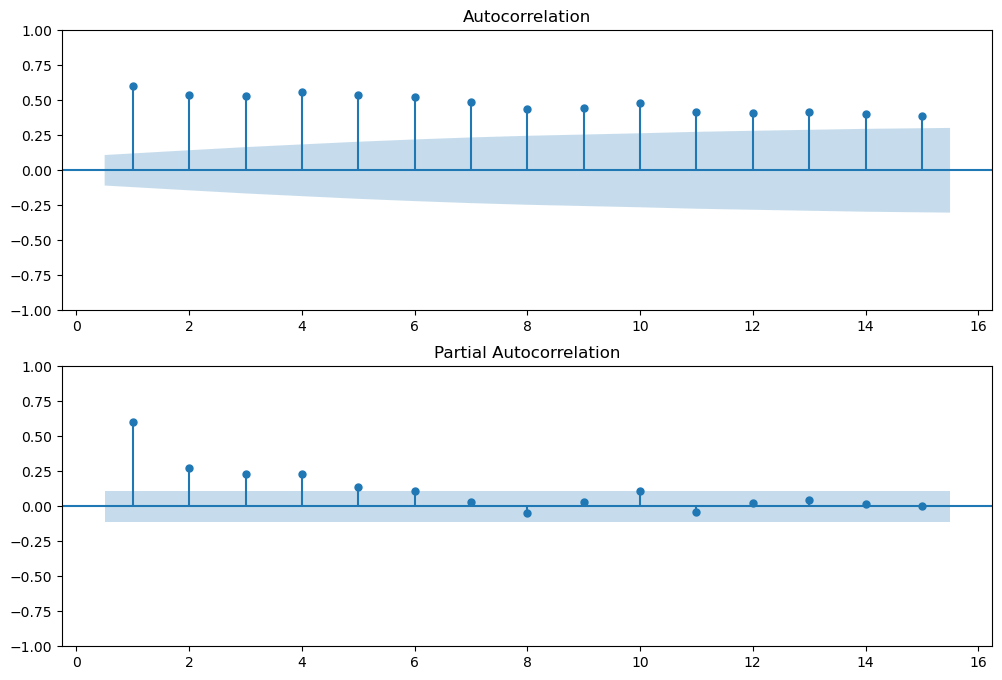

In [58]:
# Creating figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plotting the ACF on ax1
plot_acf(daily_data['Active Power (kW)'], lags=15, zero=False, ax=ax1)

# Plotting the PACF of on ax2
plot_pacf(daily_data['Active Power (kW)'], lags=15, zero=False, ax=ax2)

plt.show()


The charts represent the autocorrelation function (ACF) and the partial autocorrelation function (PACF), which are essential tools for identifying the order of autoregressive (AR) and moving average (MA) processes in time series analysis, often used for modeling with ARIMA-type models.

- **Top Chart (ACF):** This shows the autocorrelations of the time series with lags of itself. Here, the ACF shows significant correlation at multiple lag intervals that appear at a regular frequency, suggesting a seasonal pattern. The slow decay of the autocorrelation also suggests a non-stationary time series.

- **Bottom Chart (PACF):** This shows the partial autocorrelation of the time series, which is the correlation of the series with its lags that is not explained by correlations at all lower-order lags. The PACF cuts off after the first lag, suggesting that an AR term of order 1 might be appropriate for the AR part of an ARIMA model.

**Inference:**

1. **Non-Stationarity:** The ACF's slow decay indicates that the time series is likely non-stationary and may need differencing to make it stationary.

2. **Seasonality:** The regular spikes in the ACF suggest a strong seasonal component. The seasonal period can often be inferred from the lag at which the spikes occur.

3. **ARIMA Modeling:** The PACF indicates that an AR term of order 1 may be appropriate (p=1). The ACF suggests that a seasonal MA component might be considered, as indicated by the seasonal spikes.

4. **Data Transformation:** Before fitting an ARIMA model, it might be necessary to seasonally difference the data to address the non-stationarity and remove the seasonal effect.

5. **Model Specification:** For an ARIMA model, one might initially consider an AR term (from the PACF), and based on the ACF, incorporate seasonal differencing or a seasonal MA term to capture the observed seasonality. The exact terms would be further refined based on model diagnostics and validation.

In [59]:
model = ARIMA(daily_data['Active Power (kW)'], order=(2, 0, 1))

C:\Users\kalya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kalya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kalya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [60]:
results = model.fit()

# Print fit summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:      Active Power (kW)   No. Observations:                  323
Model:                 ARIMA(2, 0, 1)   Log Likelihood                  -8.327
Date:                Tue, 16 Apr 2024   AIC                             26.655
Time:                        12:17:47   BIC                             45.543
Sample:                             0   HQIC                            34.195
                                - 323                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0788      0.124      8.704      0.000       0.836       1.322
ar.L1          1.0557      0.074     14.202      0.000       0.910       1.201
ar.L2         -0.0801      0.068     -1.175      0.2

In [61]:
# Generating predictions for the last 12 periods in sample
one_step_forecast = results.get_prediction(start=-12)

# Extracting prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Getting confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

confidence_intervals
# Selecting lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Active Power (kW)']
upper_limits = confidence_intervals.loc[:,'upper Active Power (kW)']

# Printing best estimate predictions
print(mean_forecast)

DateTime
2010-11-15    1.302465
2010-11-16    1.263772
2010-11-17    1.204800
2010-11-18    1.185411
2010-11-19    1.179415
2010-11-20    1.155393
2010-11-21    1.259291
2010-11-22    1.061443
2010-11-23    1.193541
2010-11-24    1.146157
2010-11-25    1.176064
2010-11-26    1.118490
Name: predicted_mean, dtype: float64


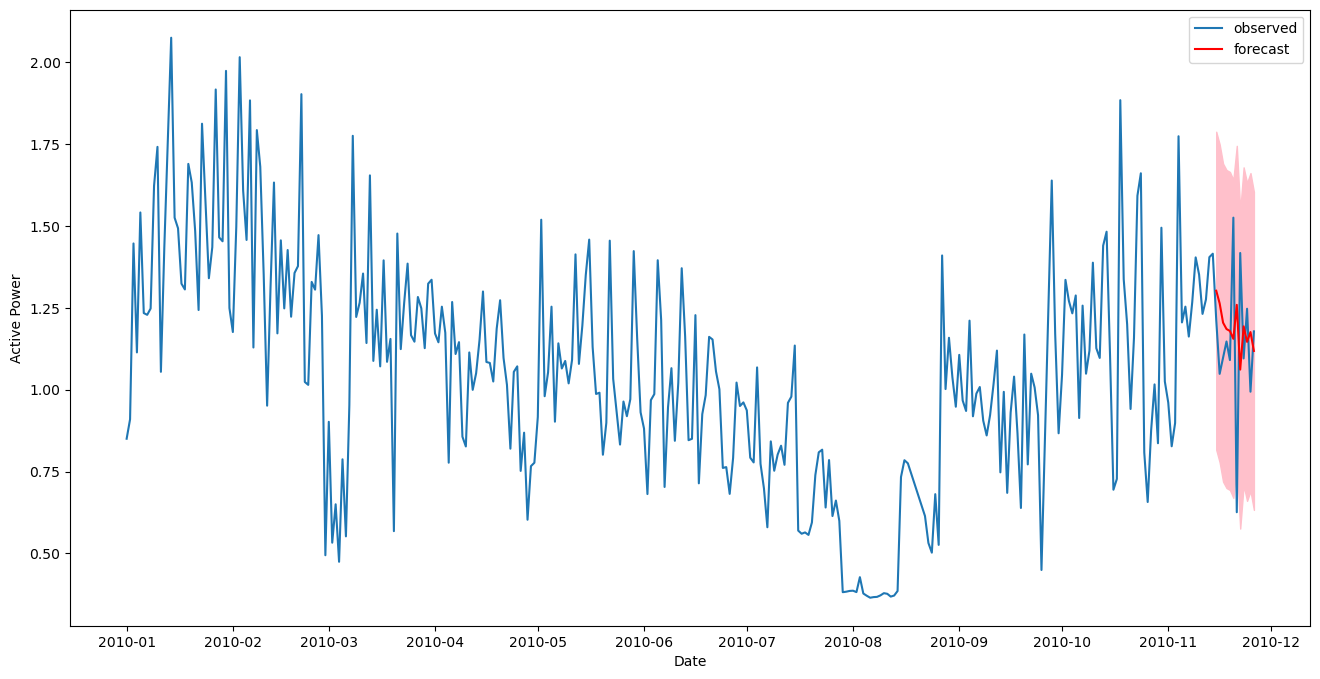

In [62]:
plt.figure(figsize=(16, 8))
# plot the  data
plt.plot(daily_data.index, daily_data['Active Power (kW)'], label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot

plt.xlabel('Date')
plt.ylabel('Active Power')
plt.legend()
plt.show()

The plot is a time series plot with both actual data (in blue) and a forecast (in red), with a shaded area representing the confidence interval for the forecast.

**Inference:**

1. **Observed Data:** The blue line represents the actual observed values of active power usage over time, which shows variability and possible seasonal patterns.

2. **Forecast:** The red line indicates the predicted values. It appears to follow the general trend of the observed data closely.

3. **Confidence Interval:** The shaded area around the forecast suggests the range within which future values are expected to fall, with a certain level of confidence. It widens as we move further out into the future, indicating increasing uncertainty in the forecast.

4. **Trend and Seasonality:** There may be underlying trends or seasonality that the model has captured to some extent, as evidenced by the forecast line following the general pattern of the observed data.

5. **Model Evaluation:** The forecast appears to diverge somewhat from the observed values toward the end of the series, indicating that the model may not fully capture all of the dynamics in the data or that there may be new patterns emerging that the model has not seen before.

6. **Forecast Utility:** Despite the divergence, the forecast could still be useful for decision-making processes if the confidence interval is acceptable for the intended use-case.

7. **Next Steps:** It would be important to continually evaluate the model’s performance as new data becomes available, and potentially retrain or adjust the model to maintain accuracy.

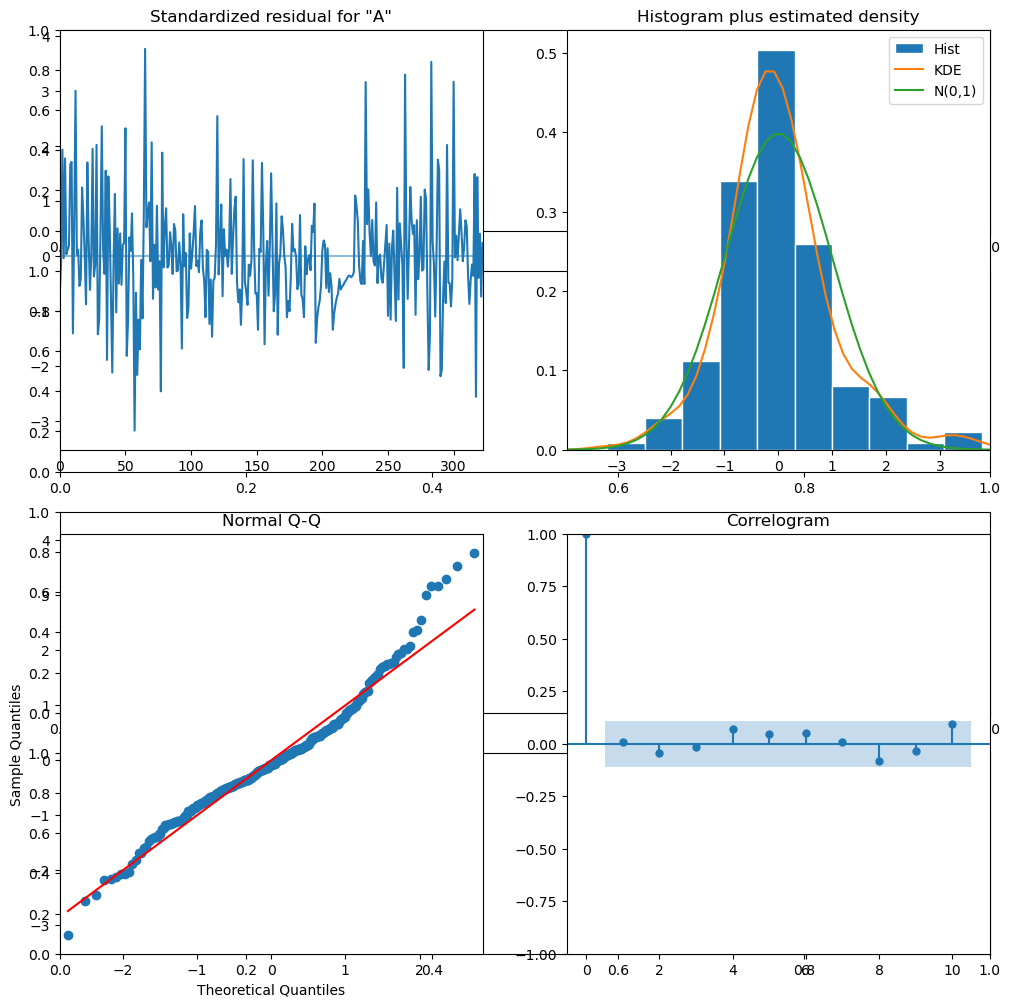

In [63]:
# Plot diagnostics
fig, axes = plt.subplots(4, 1, figsize=(12, 12)) 
results.plot_diagnostics(fig=fig)
plt.show()


The diagnostic plots for the residuals:

1. **Top Left - Standardized Residuals:** This plot shows the standardized residuals from the model over time. The residuals seem to be fluctuating around zero without clear patterns, which is generally a good sign, indicating that the model does not leave obvious, systematic errors in its predictions.

2. **Top Right - Histogram and Density Plots:** This plot includes a histogram of the residuals, a kernel density estimate (KDE), and a normal distribution (N(0,1)) for comparison. The goal is to check if the residuals are normally distributed, which is an assumption in many modeling techniques. The slight deviation from the normal distribution curve suggests that the residuals might not be perfectly normally distributed.

3. **Bottom Left - Q-Q Plot:** The Quantile-Quantile plot is a graphical technique to assess if a dataset follows a specific distribution, in this case, a normal distribution. If the points closely follow the red line, the data is normally distributed. The points in the tail deviate from the line, indicating the residuals may have heavier tails than a normal distribution.

4. **Bottom Right - Correlogram (ACF plot):** This plot shows the autocorrelation of the residuals. Ideally, we would like to see no significant autocorrelation, meaning the error terms are independent of each other. Here, all the autocorrelations for different lags seem to be within the confidence interval (shaded area), suggesting no significant autocorrelation.

**Inference:**
- The model's residuals do not show clear patterns or trends, which is good. However, there might be a slight issue with the normality assumption, as indicated by the histogram and Q-Q plot.
- There does not seem to be a problem with autocorrelation in the residuals, which is also good.
- The deviations from normality, particularly in the tails, could be a point for further investigation. This might affect the model's predictions, especially in the case of extreme values or outliers.
- Overall, the model seems to perform well based on these diagnostic plots, but some improvements might still be possible, especially in handling the tails of the residual distribution.

## LSTM

In [64]:
lstm_data = data.resample('D').mean()
# Reset index to make DateTime a column again
lstm_data.reset_index(inplace=True)
# Drop Month column if you don't need it anymore
lstm_data.drop('Month', axis=1, inplace=True)
# Drop null values from daily_data
lstm_data.dropna(inplace=True)
# Set 'DateTime' column as the index
lstm_data.set_index('DateTime', inplace=True)

In [65]:
lstm_data.head()

Active Power (kW)  Reactive Power (kW)  Voltage (V)  \
DateTime                                                          
2007-01-01           1.909031             0.102893   240.128979   
2007-01-02           0.881414             0.132182   241.943778   
2007-01-03           0.704204             0.136617   243.557090   
2007-01-04           2.263481             0.140487   239.750299   
2007-01-05           1.884281             0.120246   240.495764   

            Current Intensity (A)  Kitchen Energy (Wh)  Laundry Energy (Wh)  \
DateTime                                                                      
2007-01-01               7.916944             0.000000             0.244444   
2007-01-02               3.714028             0.000000             0.241667   
2007-01-03               3.014028             0.000000             0.238889   
2007-01-04               9.478194             0.729861             5.275694   
2007-01-05               7.885139             1.029861             0.263194   

            Water Heater & AC Energy (Wh)  
DateTime                                   
2007-01-01                       4.083333  
2007-01-02                       4.556944  
2007-01-03                       3.309028  
2007-01-04                       7.566667  
2007-01-05                       5.279167

In [66]:
lstm_data.isnull().sum()

Active Power (kW)                0
Reactive Power (kW)              0
Voltage (V)                      0
Current Intensity (A)            0
Kitchen Energy (Wh)              0
Laundry Energy (Wh)              0
Water Heater & AC Energy (Wh)    0
dtype: int64

In [67]:
lstm_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1417 entries, 2007-01-01 to 2010-11-26
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Active Power (kW)              1417 non-null   float64
 1   Reactive Power (kW)            1417 non-null   float64
 2   Voltage (V)                    1417 non-null   float64
 3   Current Intensity (A)          1417 non-null   float64
 4   Kitchen Energy (Wh)            1417 non-null   float64
 5   Laundry Energy (Wh)            1417 non-null   float64
 6   Water Heater & AC Energy (Wh)  1417 non-null   float64
dtypes: float64(7)
memory usage: 88.6 KB


Epoch 1/50
22/22 [==============================] - 1s 5ms/step - loss: 0.0426
Epoch 2/50
22/22 [==============================] - 0s 5ms/step - loss: 0.0151
Epoch 3/50
22/22 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 0.0140
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 8/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 9/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 10/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 11/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 12/50
22/22 [==============================] - 0s 5ms/step - loss: 0.0137
Epoch 13/50
22/22 [==============================

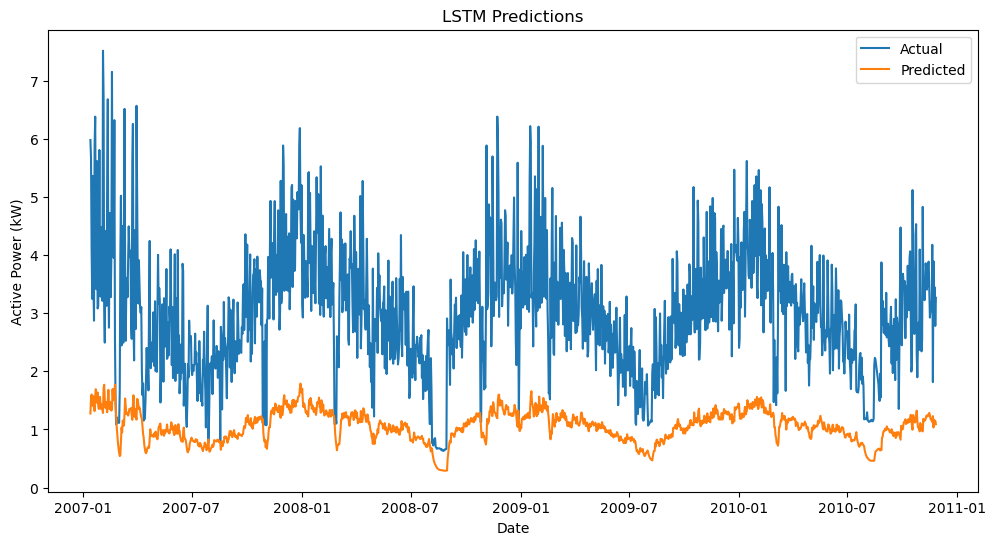

In [73]:
daily_data = lstm_data.copy()

# Preprocess the data

values = daily_data['Active Power (kW)'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Define sequence length

seq_length = 12

# Create sequences
X, y = create_sequences(scaled_values, seq_length)

# Reshape input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], 1)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=50, batch_size=64, verbose=1)

# Make predictions
predictions = model.predict(X)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index[seq_length:], scaler.inverse_transform(values)[seq_length:], label='Actual')
plt.plot(daily_data.index[seq_length:], scaler.inverse_transform(predictions), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Active Power (kW)')
plt.title('LSTM Predictions')
plt.legend()
plt.show()


## Optimizing of LSTM by varying parameters.

In [83]:
daily_data = lstm_data.copy()

values = daily_data['Active Power (kW)'].values.reshape(-1, 1)

# Normalization of data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(daily_data['Active Power (kW)'].values.reshape(-1, 1))

# Function to create a dataset for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)


In [84]:
# Creating sequences with look-back period
seq_length = 365  # This is equivalent to a 365-day look-back for data which is a daily data
X, y = create_sequences(scaled_values, seq_length)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [85]:
# LSTM Network
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

In [86]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# Compiling
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Splitting data into train and test sets
split_idx = int(len(X) * 0.8)  # 80% for training
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [87]:
# Training the model with a validation set
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint]
)

# Loading best model from checkpoint
model.load_weights('best_model.h5')

# Predicting and inverse transforming the scaling
predictions = model.predict(X)
predictions_rescaled = scaler.inverse_transform(predictions)

Epoch 1/200
14/14 [==============================] - 10s 518ms/step - loss: 0.0476 - val_loss: 0.0137
Epoch 2/200
14/14 [==============================] - 7s 466ms/step - loss: 0.0188 - val_loss: 0.0106
Epoch 3/200
14/14 [==============================] - 7s 490ms/step - loss: 0.0160 - val_loss: 0.0105
Epoch 4/200
14/14 [==============================] - 7s 503ms/step - loss: 0.0152 - val_loss: 0.0095
Epoch 5/200
14/14 [==============================] - 6s 465ms/step - loss: 0.0155 - val_loss: 0.0095
Epoch 6/200
14/14 [==============================] - 6s 446ms/step - loss: 0.0155 - val_loss: 0.0095
Epoch 7/200
14/14 [==============================] - 6s 442ms/step - loss: 0.0155 - val_loss: 0.0091
Epoch 8/200
14/14 [==============================] - 7s 474ms/step - loss: 0.0144 - val_loss: 0.0091
Epoch 9/200
14/14 [==============================] - 6s 462ms/step - loss: 0.0147 - val_loss: 0.0091
Epoch 10/200
14/14 [==============================] - 6s 455ms/step - loss: 0.0142 - val_l

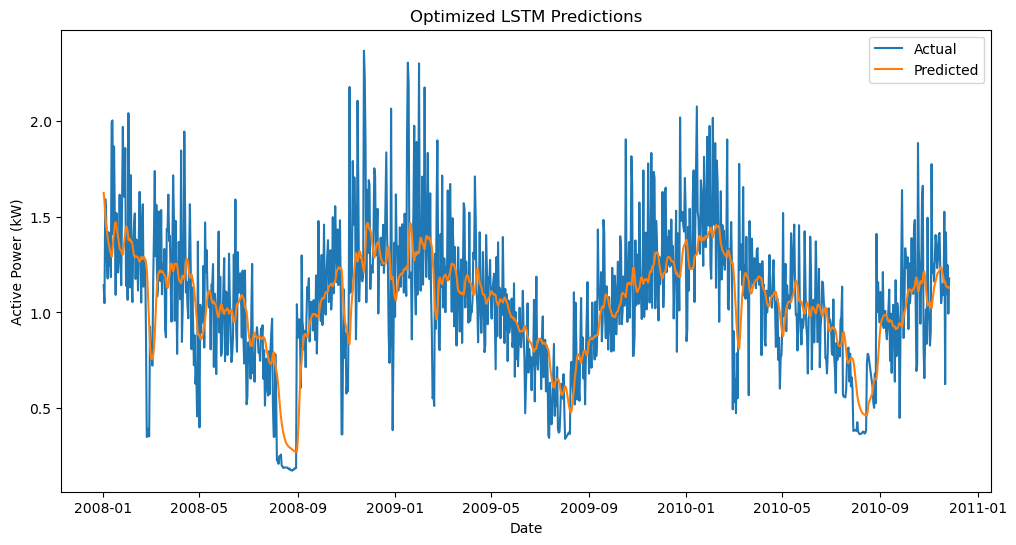

In [88]:
# Plotting actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index[seq_length:], scaler.inverse_transform(y.reshape(-1, 1)), label='Actual')
plt.plot(daily_data.index[seq_length:], predictions_rescaled, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Active Power (kW)')
plt.title('Optimized LSTM Predictions')
plt.legend()
plt.show()

## LSTM Model Performance Analysis

### Overview
The chart depicts a comparison between actual and predicted Active Power (kW) values over time, spanning from January 2008 to around January 2011. The actual values are represented in blue, while the predicted values from the Optimized LSTM model are shown in orange.

- The LSTM model closely tracks the actual power consumption trend.
- Predictions capture overall seasonality and fluctuations well, indicating effective learning of data patterns.
- Predicted values exhibit smoothing effect, typical in LSTM models, reflecting underlying trends rather than every peak and trough.

### Observations
- Good accuracy in following dips and rises in power consumption.
- Some discrepancies between predicted and actual data exist.
- Potential areas for model improvement: hyperparameter tuning, additional feature engineering, or incorporating more historical context.

The LSTM model demonstrates promising performance in capturing the underlying trends and seasonality in power consumption data. However, there is room for improvement to reduce prediction errors and enhance accuracy.


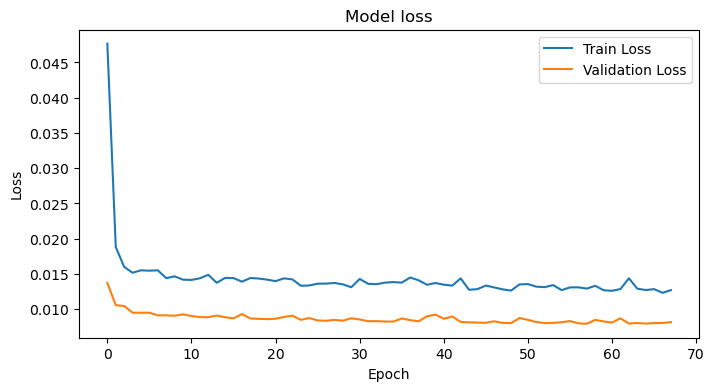

In [89]:
# Analyzing the loss over epochs
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [97]:
# Assuming predictions are generated from the model directly:
predictions = model.predict(X_test)

# Ensure predictions are correctly shaped (as they should directly match y_test):
predictions = predictions[:len(y_test)]  # Truncate predictions if necessary

# Rescale predictions to the original scale
predictions_rescaled = scaler.inverse_transform(predictions)

# Now calculate RMSE
rmse = sqrt(mean_squared_error(scaler.inverse_transform(y_test), predictions_rescaled))
print("RMSE: ", rmse)


7/7 [==============================] - 1s 85ms/step
RMSE:  0.2340499685155571
